In [1]:
import matplotlib.pyplot as plt
import pandas as pd 
from pyspark.sql import SparkSession


# Create Spark session
spark = SparkSession.builder \
    .appName("Project") \
    .master("spark://spark-master:7077") \
    .getOrCreate()

player_avg_df = spark.read.csv("hdfs://namenode:9000/player_per_game.csv", header=True, inferSchema=True)

team_avg_df = spark.read.csv("hdfs://namenode:9000/team_stats_per_game.csv", header=True, inferSchema=True)

player_info_df = spark.read.csv("hdfs://namenode:9000/player_season_info.csv", header=True, inferSchema=True)

player_shooting_df = spark.read.csv("hdfs://namenode:9000/player_shooting.csv", header=True, inferSchema=True)

per_36_min_df = spark.read.csv("hdfs://namenode:9000/per_36_min.csv", header=True, inferSchema=True)


# CRUD Operation

In [2]:
from pyspark.sql import functions as f

# make a copy of the player_avg_df
player_avg_df_copy = player_avg_df.select("*")

# add "starter" column based on minutes played
player_avg_df_copy = player_avg_df_copy.withColumn(
    "starter", 
    f.when(player_avg_df.mp_per_game > 20, True).otherwise(False)
)

# save file to hdfs
player_avg_df_copy.write.mode("overwrite").csv("hdfs://namenode:9000/modified_player_per_game.csv", header=True)


# Preprocessing

In [3]:
# filter out non NBA data
player_avg_df = player_avg_df.filter(player_avg_df.lg == "NBA")
team_avg_df = team_avg_df.filter(team_avg_df.lg == "NBA")
player_info_df = player_info_df.filter(player_info_df.lg == "NBA")
player_shooting_df = player_shooting_df.filter(player_shooting_df.lg == "NBA")
per_36_min_df = per_36_min_df.filter(per_36_min_df.lg == "NBA")

# list of columns to drop
player_avg_dc = ["seas_id", "player_id", "birth_year", "pos", "age", "experience", "g", "gs", "fg_per_game", "fga_per_game", "fg_percent", "x3p_per_game", "x3pa_per_game", "x3p_percent", "x2p_per_game", "x2pa_per_game", "x2p_percent", "e_fg_percent", "ft_per_game", "fta_per_game", "ft_percent", "orb_per_game", "drb_per_game", "trb_per_game", "ast_per_game", "stl_per_game", "blk_per_game", "tov_per_game", "pf_per_game"]
team_avg_dc = ["playoffs", "g", "mp_per_game", "fg_per_game", "fga_per_game", "fg_percent", "x3p_per_game", "x3pa_per_game", "x3p_percent", "x2p_per_game", "x2pa_per_game", "x2p_percent", "ft_per_game", "fta_per_game", "ft_percent", "orb_per_game", "drb_per_game", "trb_per_game", "ast_per_game", "stl_per_game", "blk_per_game", "tov_per_game", "pf_per_game"]
player_info_dc = ["seas_id", "player_id", "birth_year", "pos", "age", "experience"]
player_shooting_dc = ["seas_id", "player_id", "birth_year", "pos", "age", "experience", "g", "mp", "fg_percent", "avg_dist_fga", "percent_fga_from_x2p_range", "fg_percent_from_x2p_range", "fg_percent_from_x0_3_range", "fg_percent_from_x3_10_range", "fg_percent_from_x10_16_range", "fg_percent_from_x16_3p_range", "percent_assisted_x2p_fg", "percent_assisted_x3p_fg", "percent_dunks_of_fga", "num_of_dunks", "percent_corner_3s_of_3pa", "corner_3_point_percent", "num_heaves_attempted", "num_heaves_made"]
per_36_min_dc= ["seas_id", "player_id", "birth_year", "age", "experience", "g", "gs", "mp", "fg_per_36_min", "fga_per_36_min", "fg_percent", "x3p_per_36_min", "x3pa_per_36_min", "x3p_percent", "x2p_per_36_min", "x2pa_per_36_min", "x2p_percent", "ft_per_36_min", "fta_per_36_min", "ft_percent", "orb_per_36_min", "drb_per_36_min", "trb_per_36_min", "pf_per_36_min"]


# drop colums
player_avg_df = player_avg_df.drop(*player_avg_dc)
team_avg_df = team_avg_df.drop(*team_avg_dc)
player_info_df = player_info_df.drop(*player_info_dc)
player_shooting_df = player_shooting_df.drop(*player_shooting_dc)
per_36_min_df = per_36_min_df.drop(*per_36_min_dc)

# Create views 

In [4]:
player_avg_df.createOrReplaceTempView("player_averages")
team_avg_df.createOrReplaceTempView("team_averages")
player_info_df.createOrReplaceTempView("player_info")
player_shooting_df.createOrReplaceTempView("player_shooting")
per_36_min_df.createOrReplaceTempView("per_36_min")

# Find the score contribution percentage of top 5 scorers on each team 

Used to determine if a teams offence is over reliant of certain players which could pose as a vulnerability if those players are injured or targetted by the oppositions defence. For example, team TOR has a fairly even distribution of team points scored by their top scores. Where as in team OKC, majority of the points are scored by a single player, coaches could focus on developing offensive capabilities of other players.

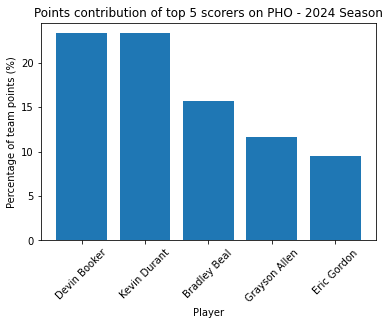

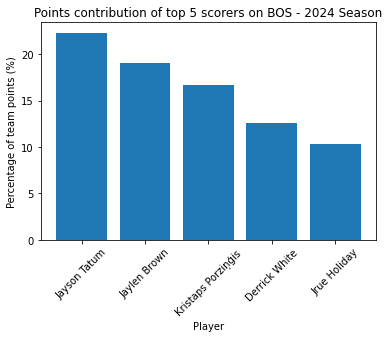

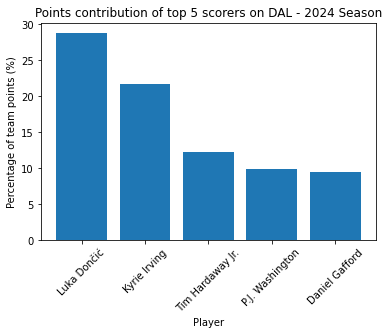

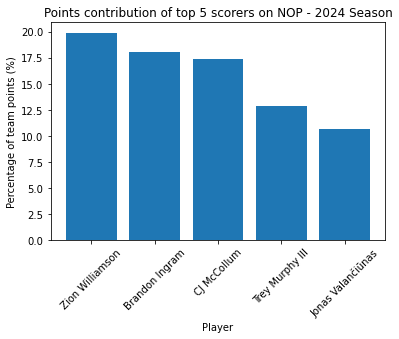

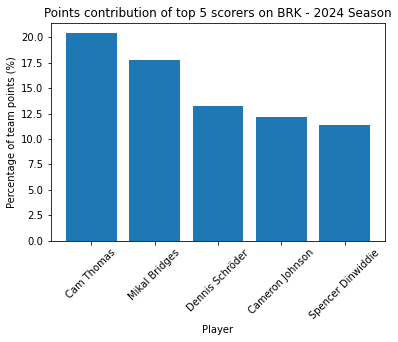

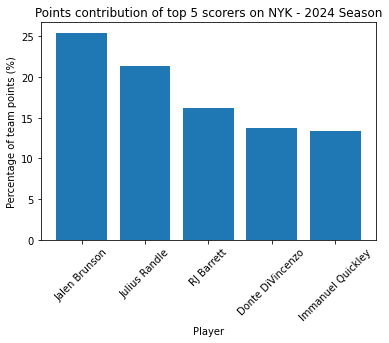

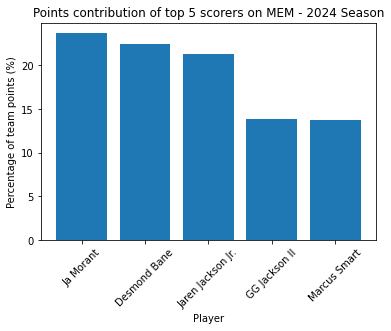

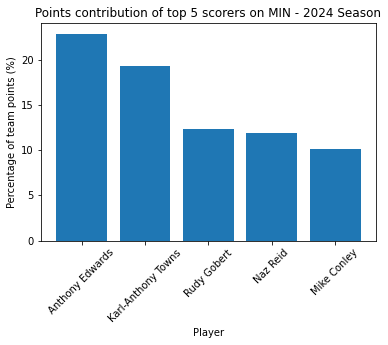

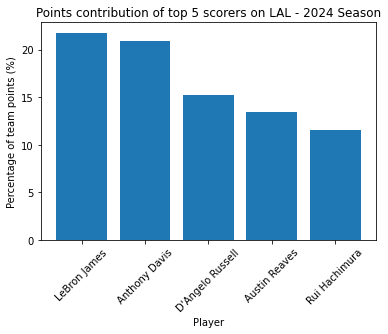

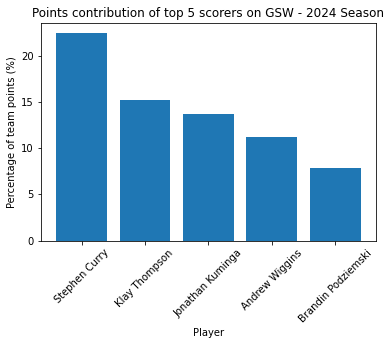

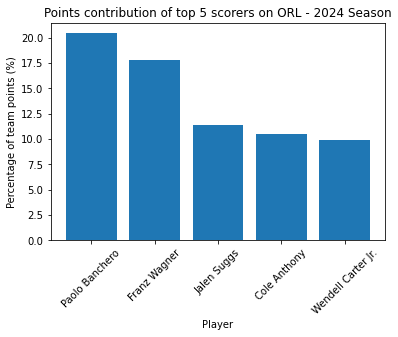

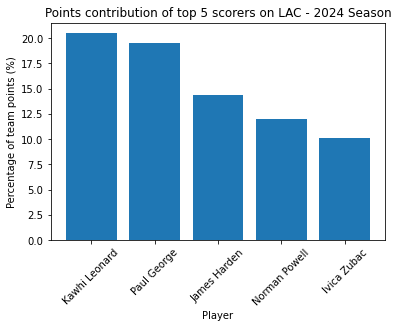

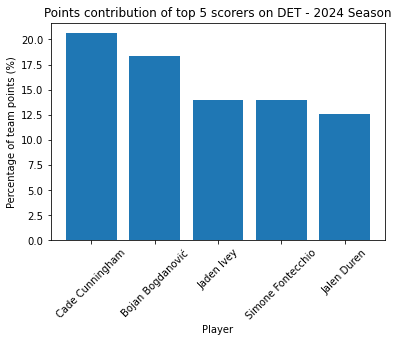

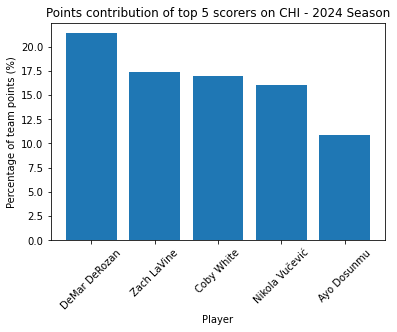

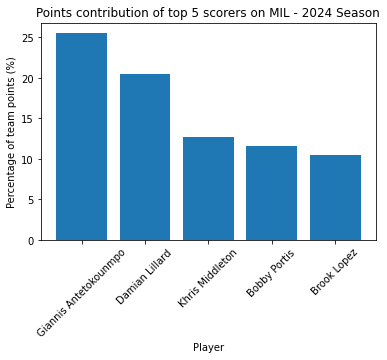

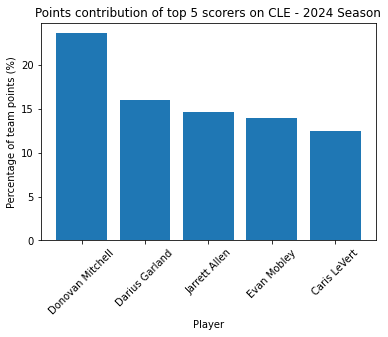

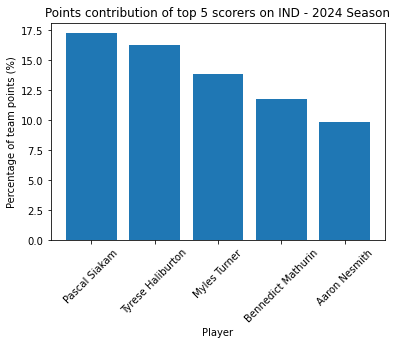

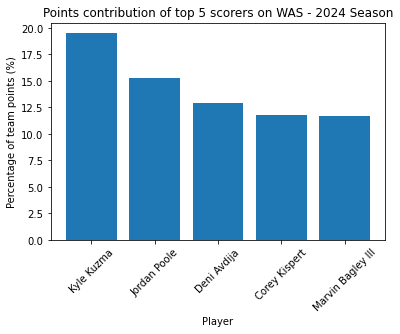

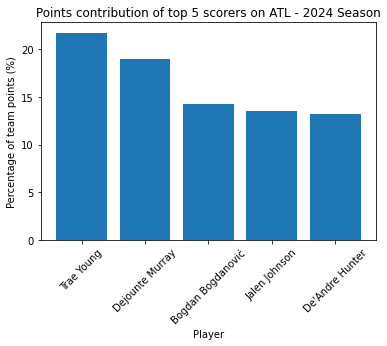

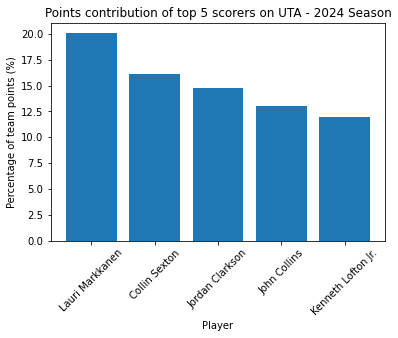

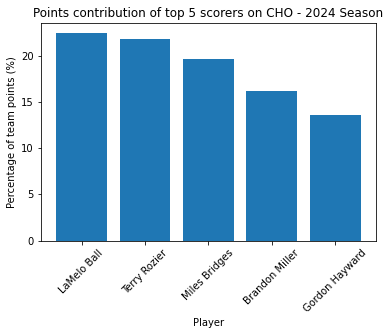

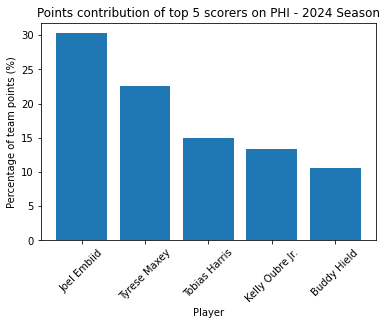

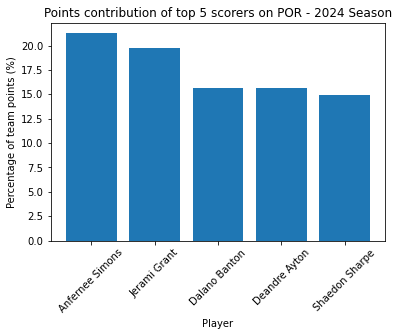

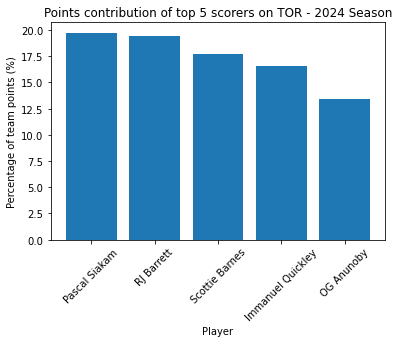

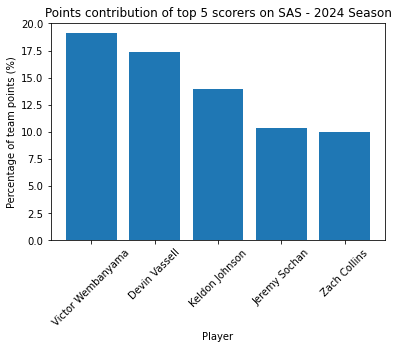

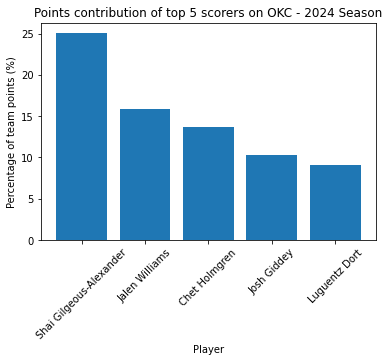

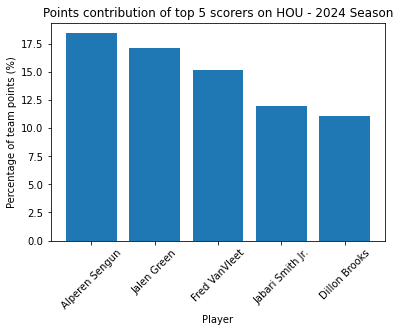

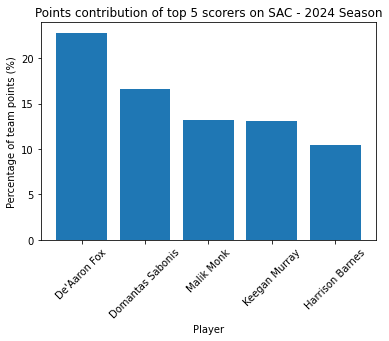

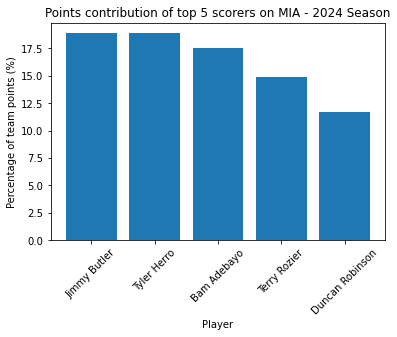

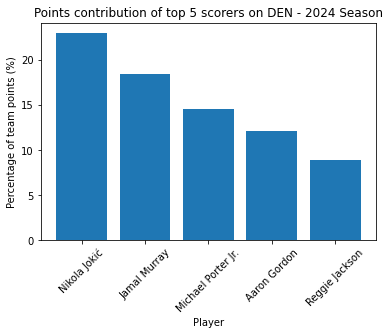

In [5]:
score_contribution = spark.sql("""
SELECT 
p.player,
p.season,
p.tm AS team,
(p.pts_per_game/ t.pts_per_game) * 100 AS percentage_of_team_points,
ROW_NUMBER() OVER (PARTITION BY t.team ORDER BY (p.pts_per_game / t.pts_per_game) DESC) AS rank
FROM player_averages p
JOIN team_averages t 
ON p.tm = t.abbreviation AND t.season = p.season 
WHERE p.season = 2024
""")

score_contribution = score_contribution.filter("rank <= 5").toPandas()

# plot team point contribution percentage for top 5 players of each team
for team in score_contribution['team'].unique():
    team_data = score_contribution[score_contribution['team'] == team]
    plt.bar(team_data['player'],
            team_data['percentage_of_team_points'])

    plt.xlabel('Player')
    plt.ylabel('Percentage of team points (%)')
    plt.title(f'Points contribution of top 5 scorers on {team} - 2024 Season')
    plt.xticks(rotation=45)
    plt.show()


# Find the three point accuracy changes over the past 5 seasons for players on a team (example: team LAC)

Tracks the 3 point accuracy of players on a team compared to the league average. This allows coaches to identify players that may require additional training. Tracking changes between seasons can also help to determine if new training programs or shooting coaches have been effective in improving player performance. For example, Russel Westbrook has been shooting below average for the last 5 seasons, indicating a potential weakness.

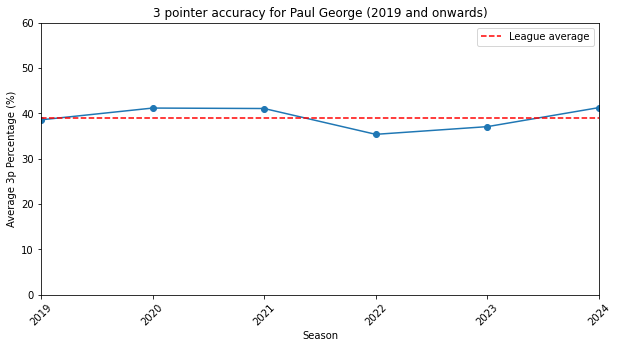

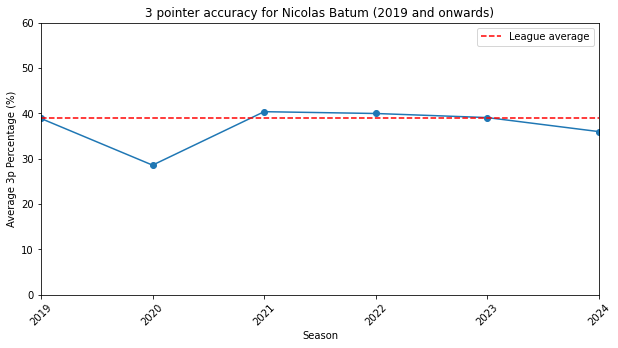

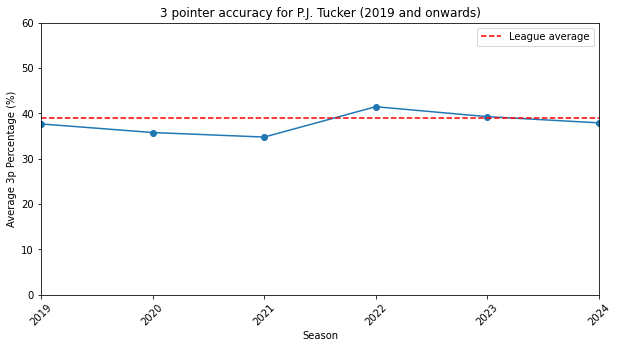

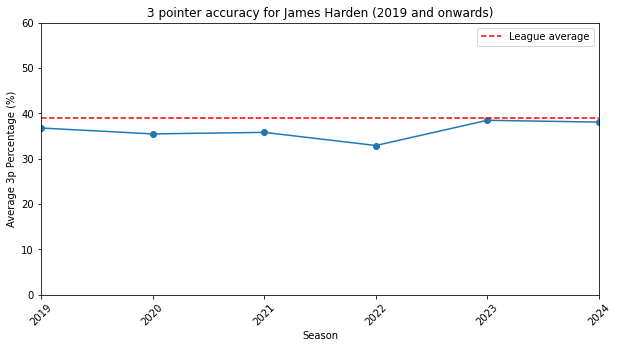

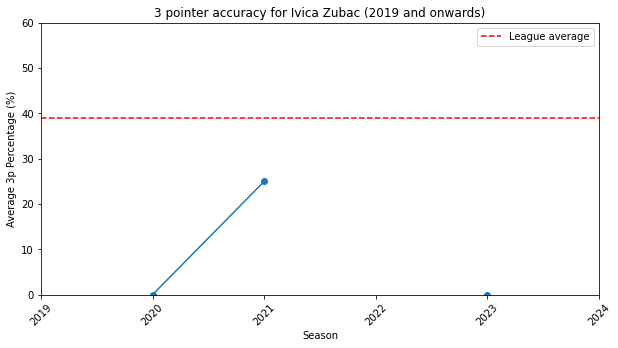

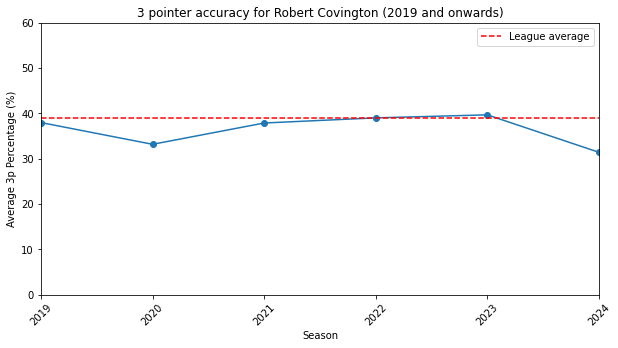

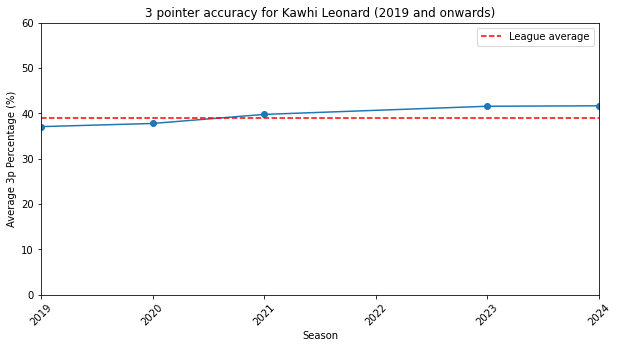

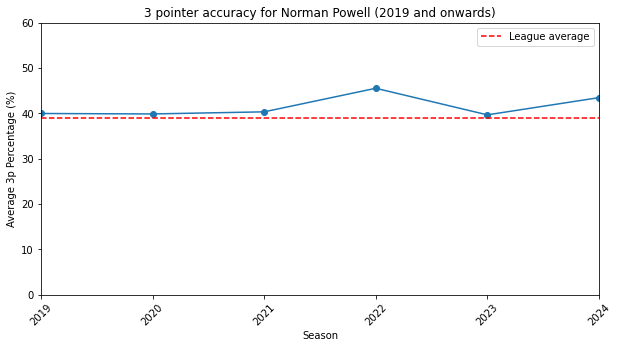

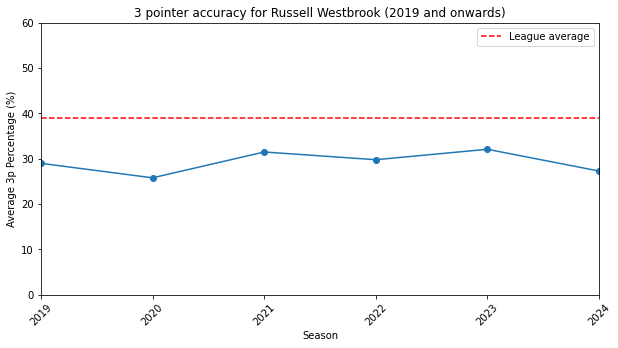

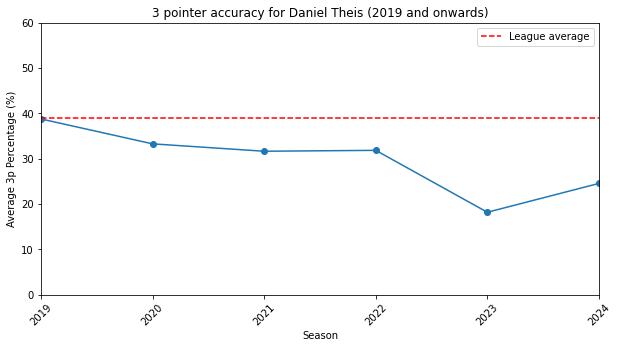

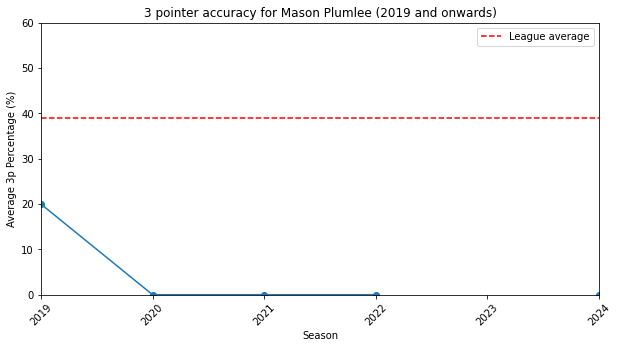

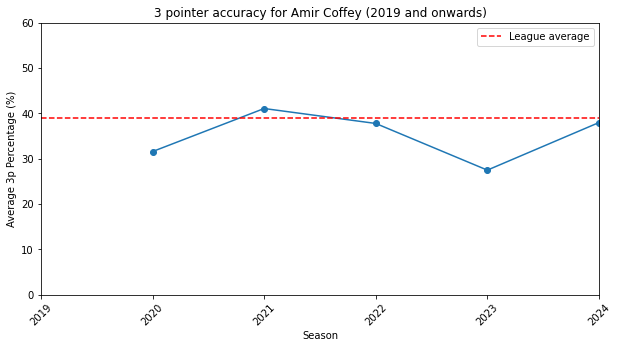

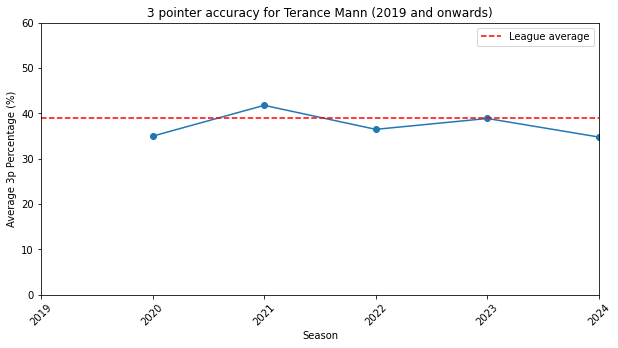

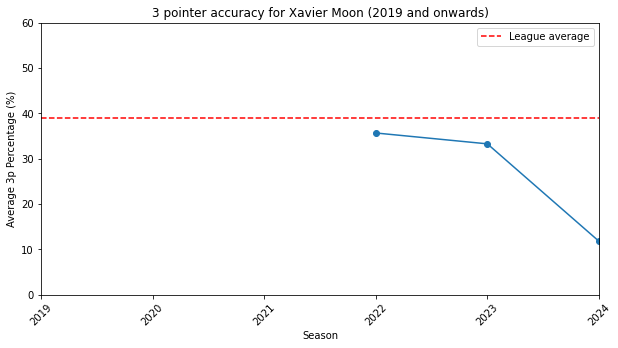

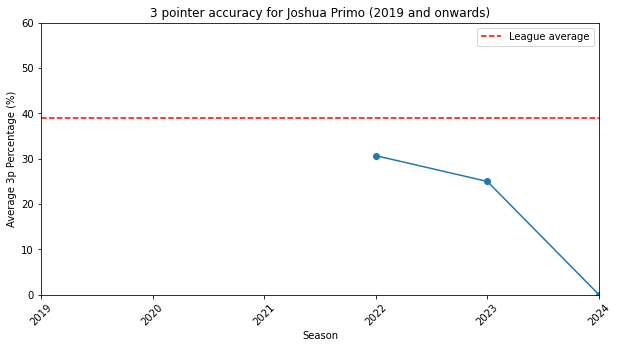

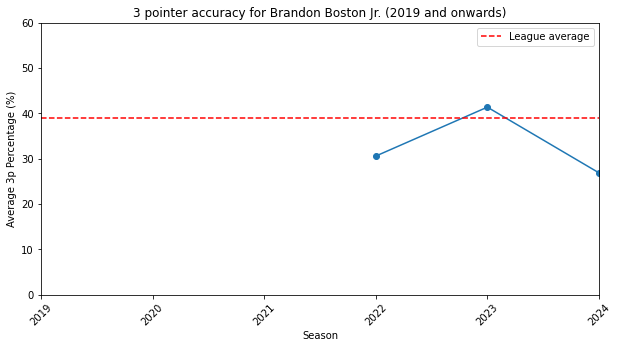

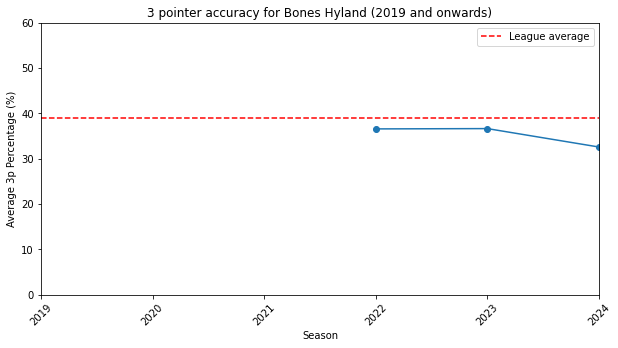

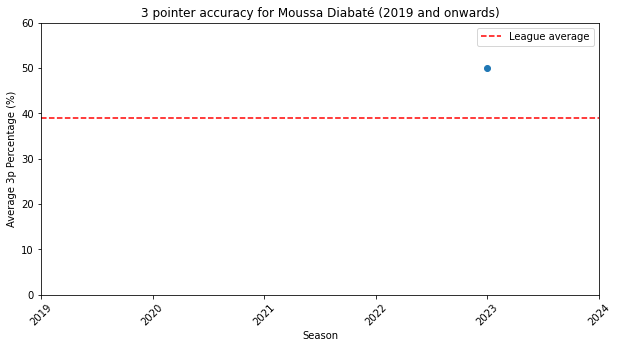

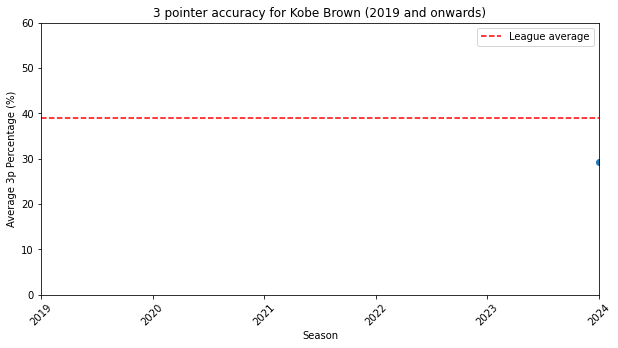

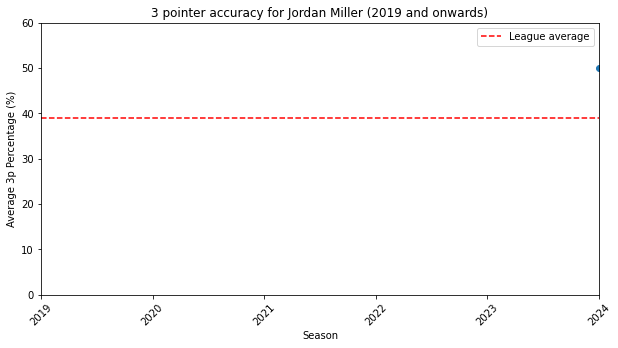

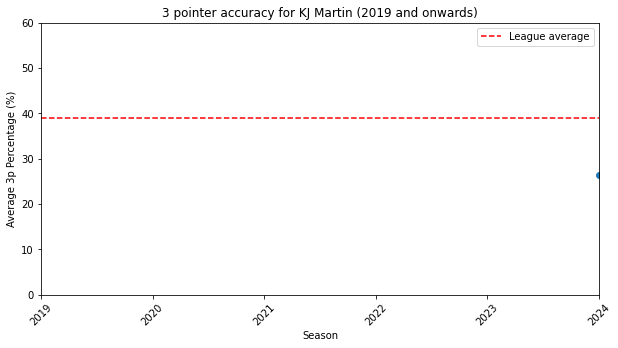

In [6]:
three_point_accuracy = spark.sql("""
SELECT 
s.season, 
p.player, 
AVG(fg_percent_from_x3p_range) *100 AS avg_3p_percent
FROM player_info p
JOIN player_shooting s
ON p.player = s.player AND p.season = s.season
WHERE p.season >= 2019
AND p.player IN (
    SELECT player
    FROM player_info
    WHERE season = 2024 and tm = "LAC"   
)
GROUP BY s.season, p.player
ORDER BY s.season 
""").toPandas()


# Create a plot for each active LAC player in the 2024 season
for player in three_point_accuracy['player'].unique():
    player_data = three_point_accuracy[three_point_accuracy['player'] == player]
    
    plt.figure(figsize=(10, 5))  
    plt.plot(player_data['season'], player_data['avg_3p_percent'], marker='o')
    

    plt.title(f'3 pointer accuracy for {player} (2019 and onwards)')
    plt.xlabel('Season')
    plt.ylabel('Average 3p Percentage (%)')
    plt.xticks(rotation=45)
    plt.xticks([2019, 2020, 2021, 2022, 2023, 2024])
    plt.xlim(2019, 2024) 
    plt.axhline(y=39, color='r', linestyle='--', label='League average')  
    plt.legend()
    plt.ylim(0, 60)  
    plt.show() 


# Find the shot selection of top scorers on each team 

This helps coaches formulate defensive strategies by identify the strenght of opposing players. For example, when looking at team GSW, their two top scorers Stephen Curry and Klay Thompson both shoot primarily score from long range with over 60% of their shots from beyond the three point line. In comparison, a low percentage of shots were attempted from under the post. Coaches can then alter their defensive strategies to focus on perimeter defence when facing the GSW team.

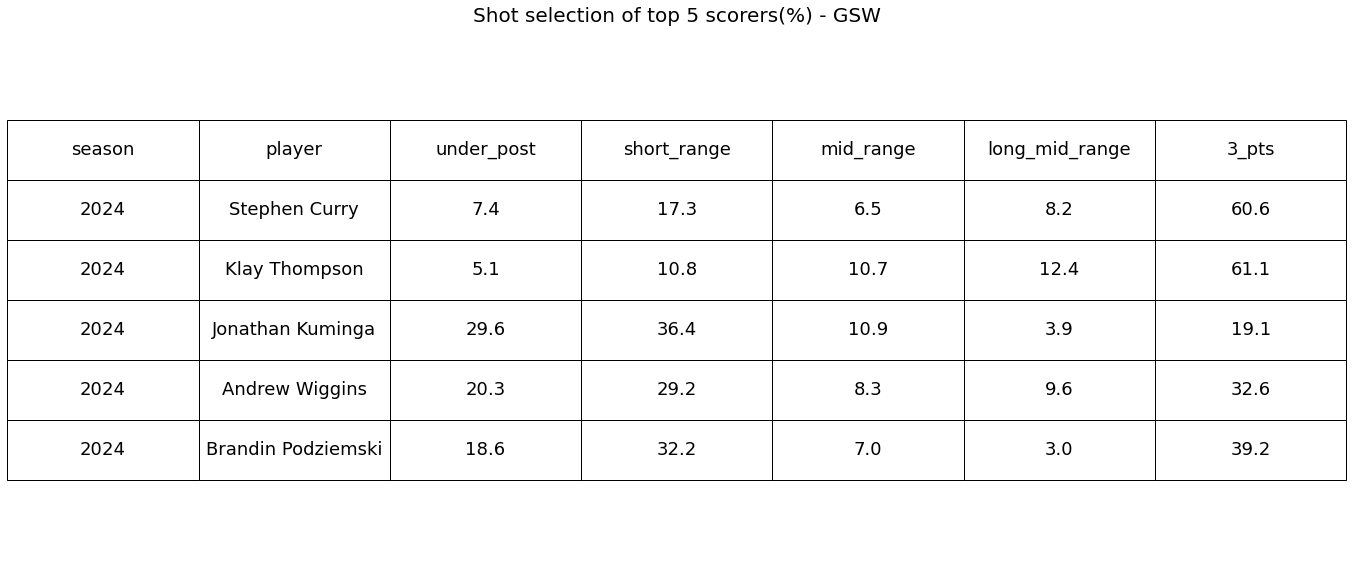

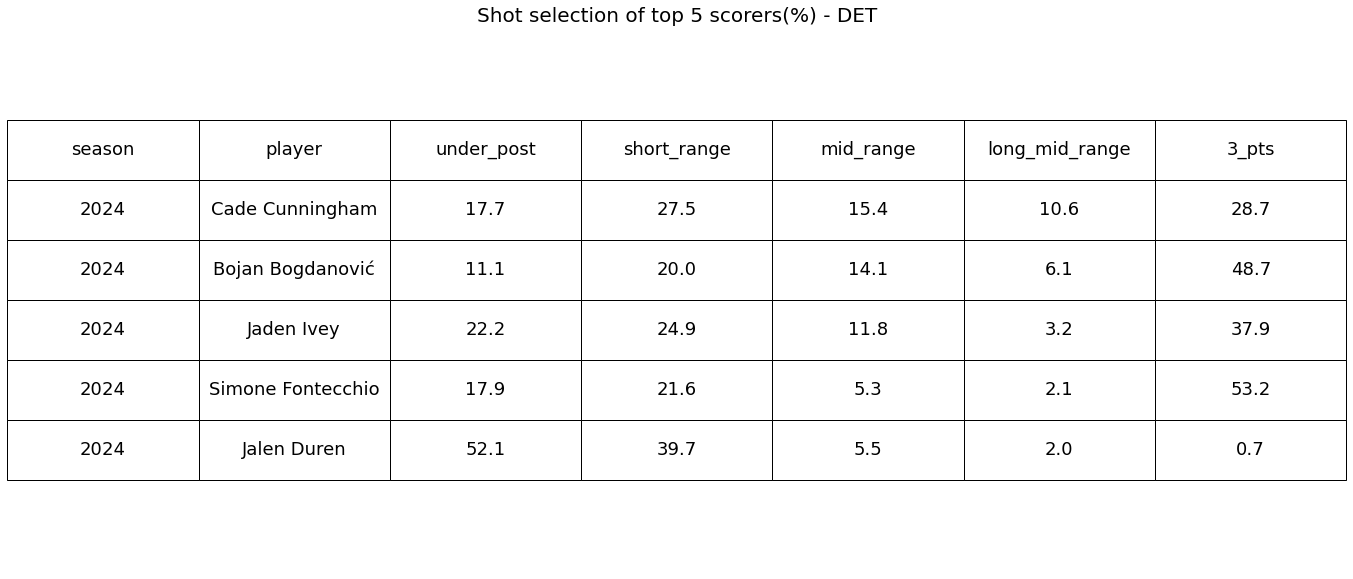

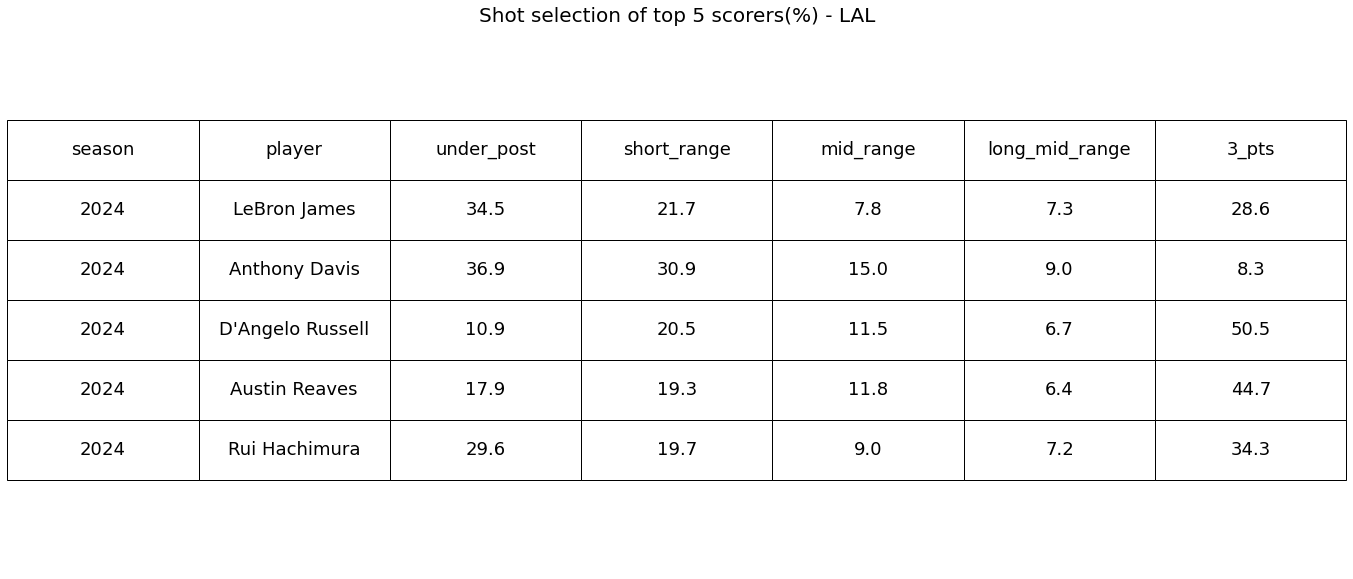

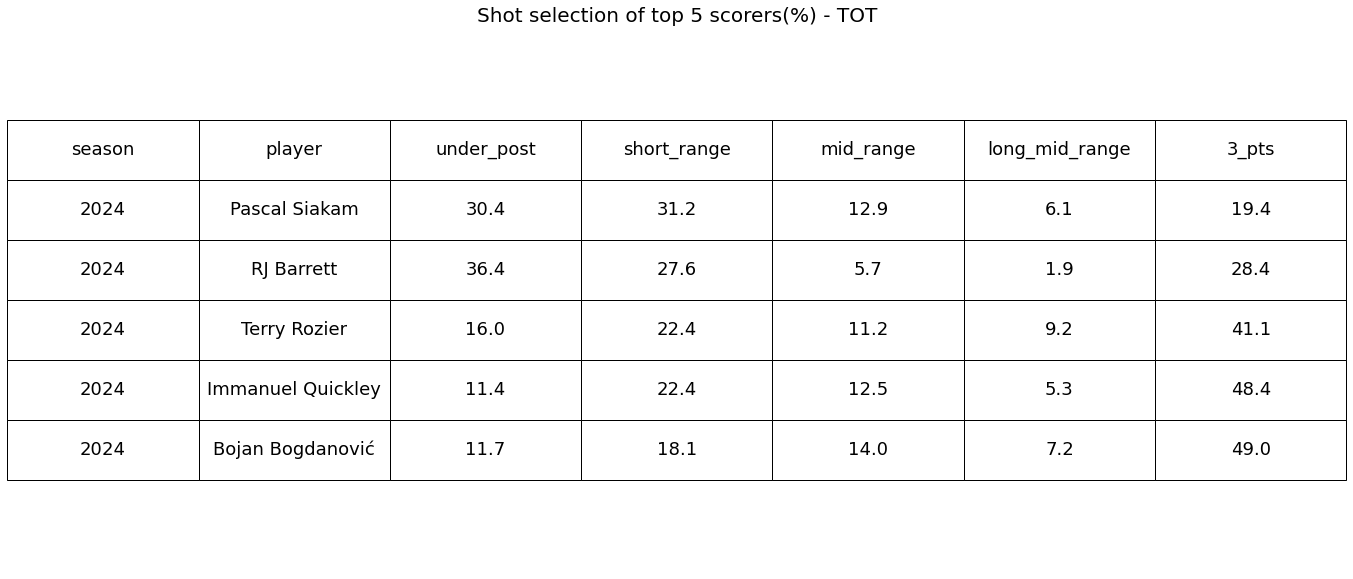

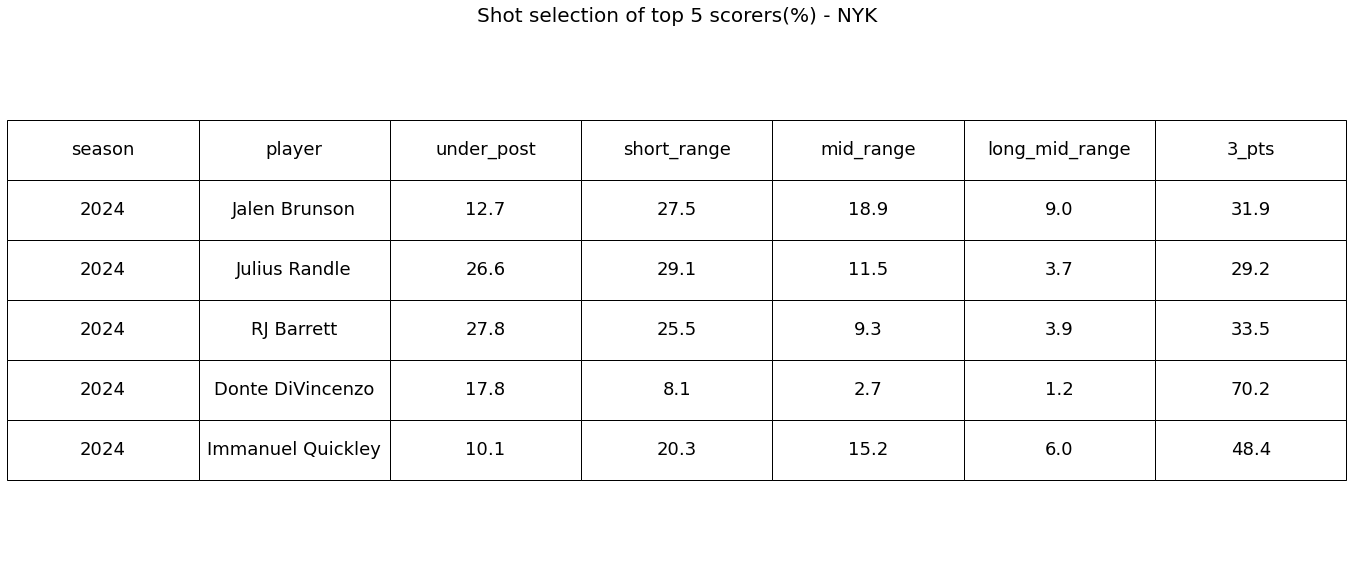

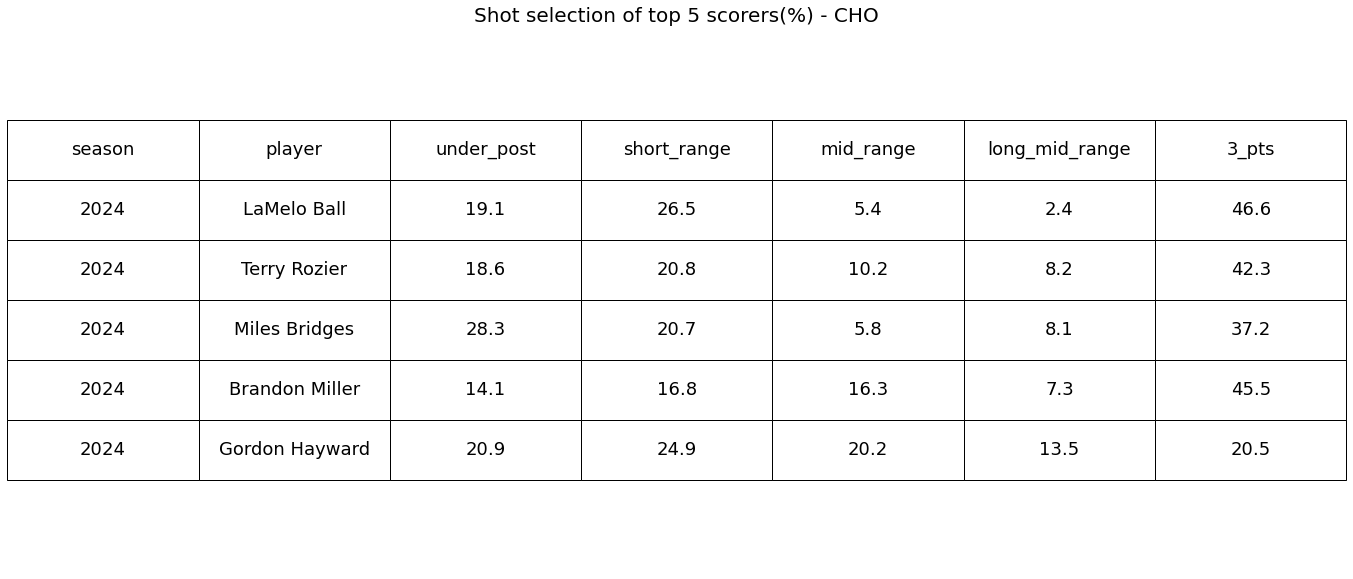

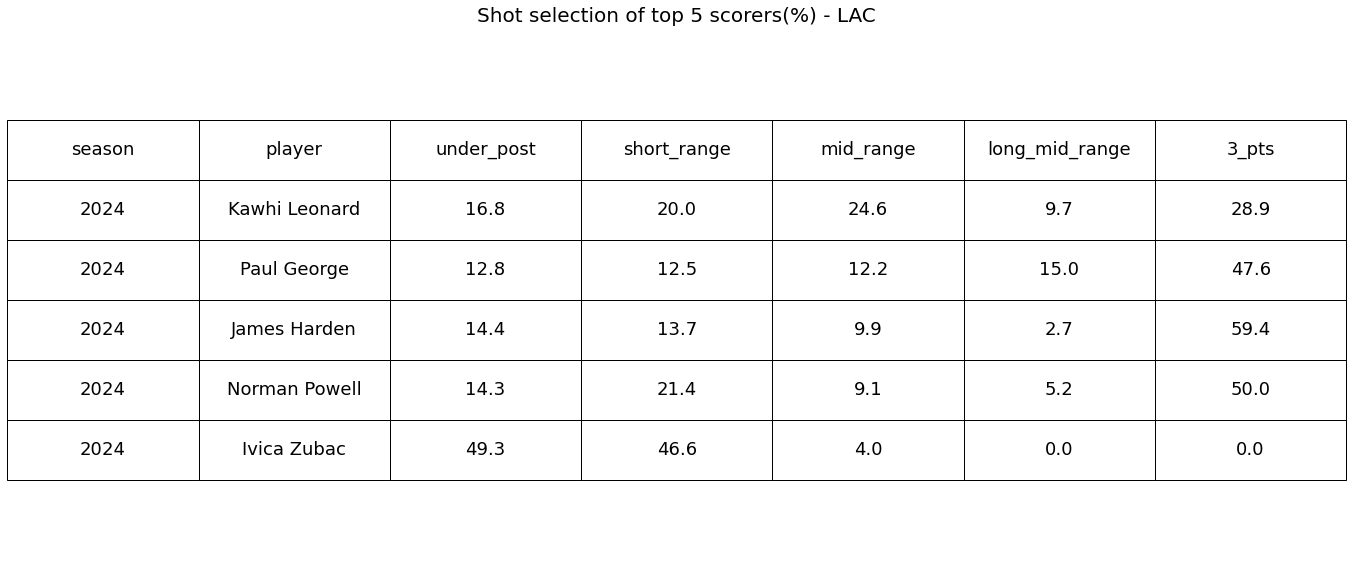

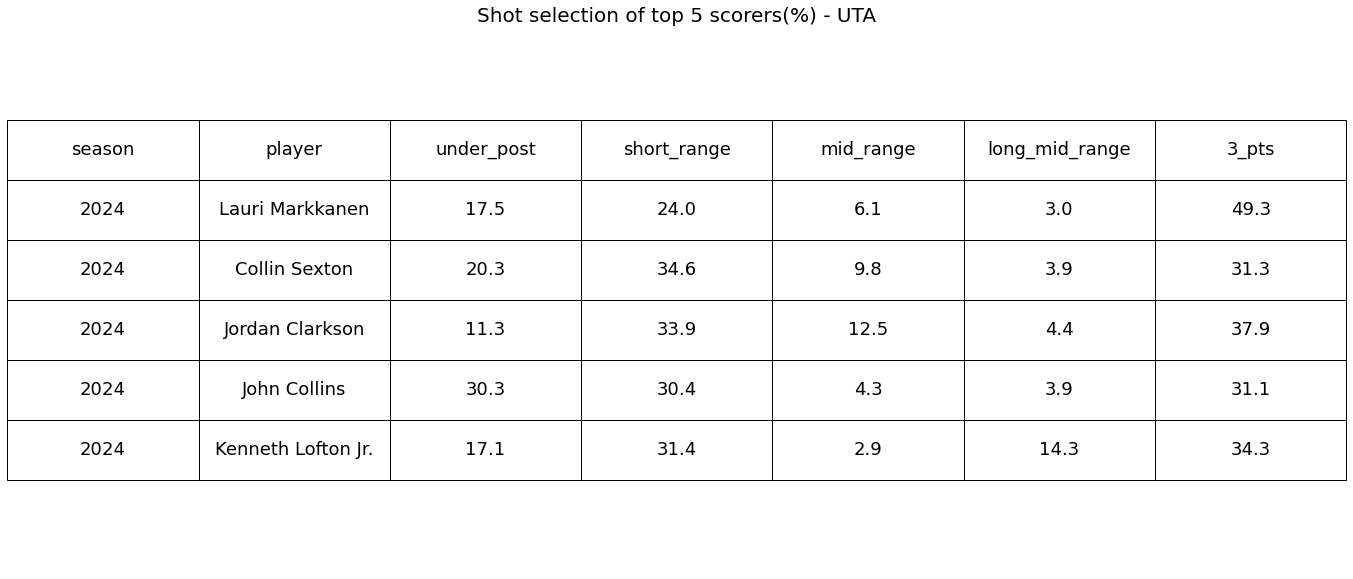

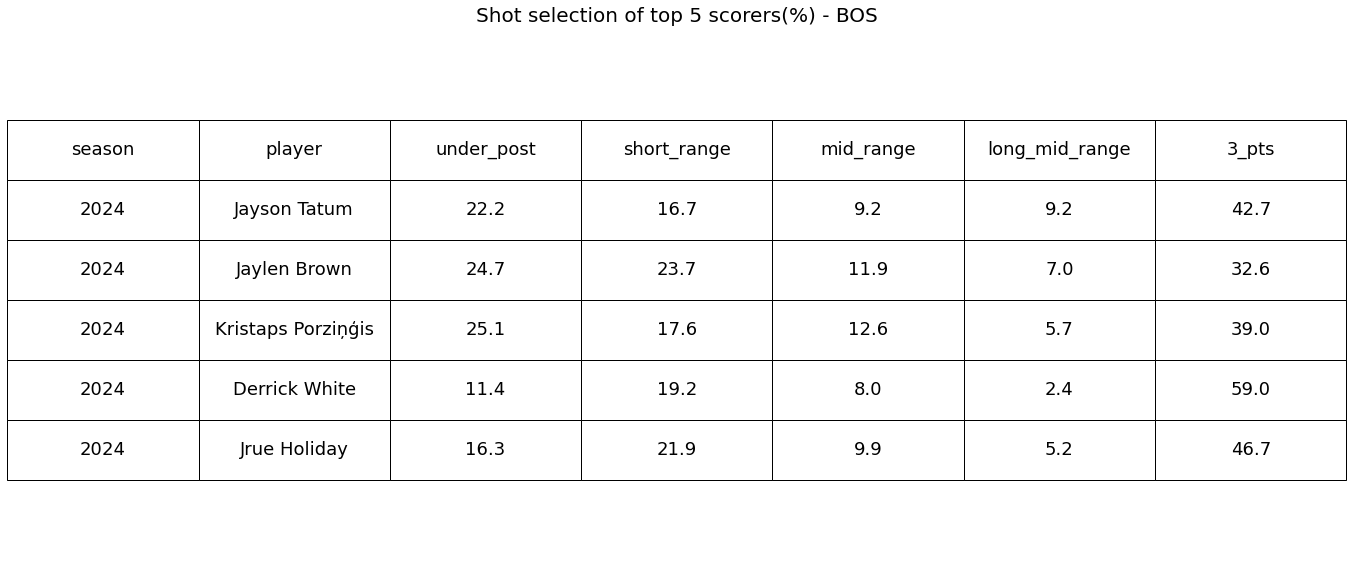

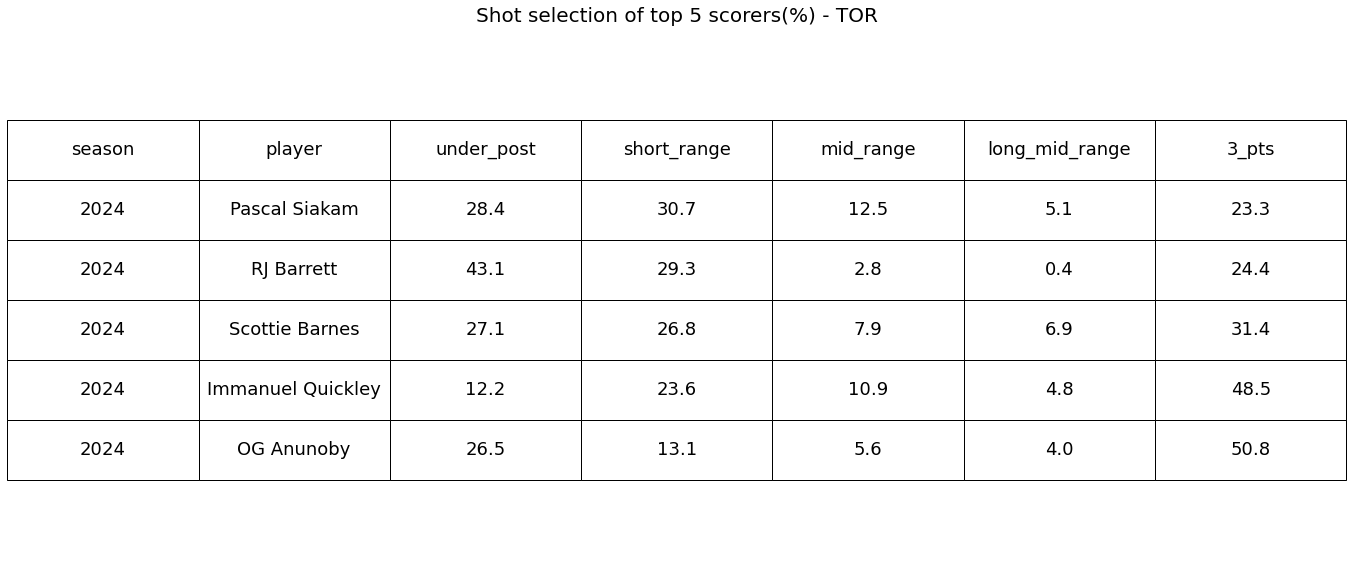

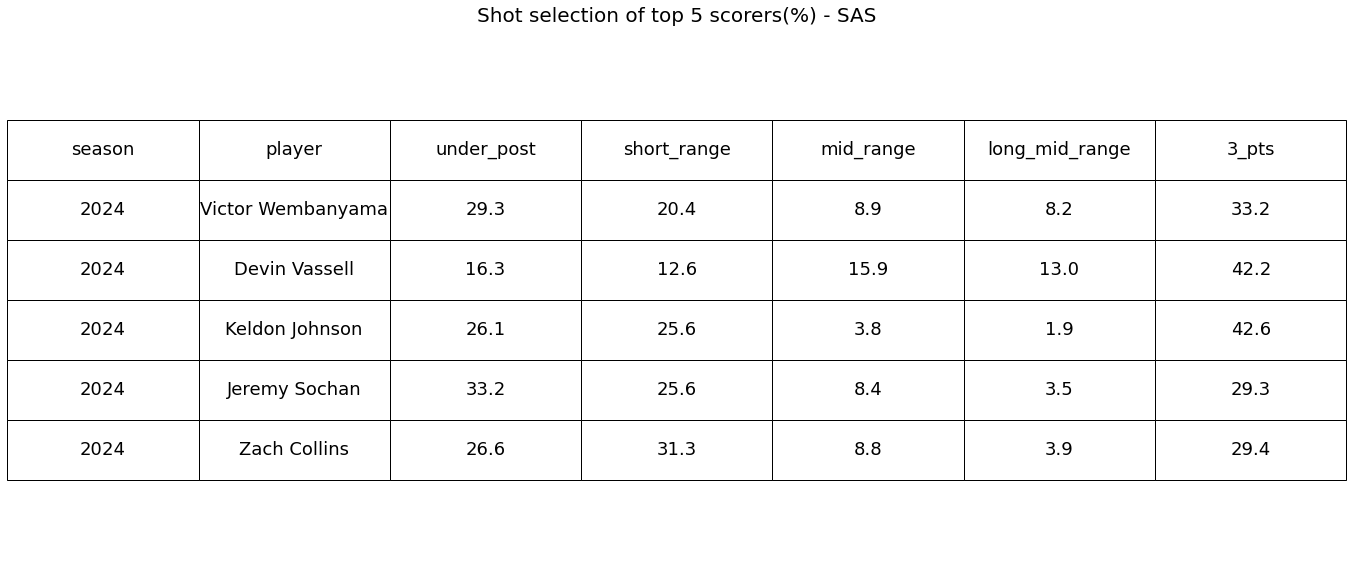

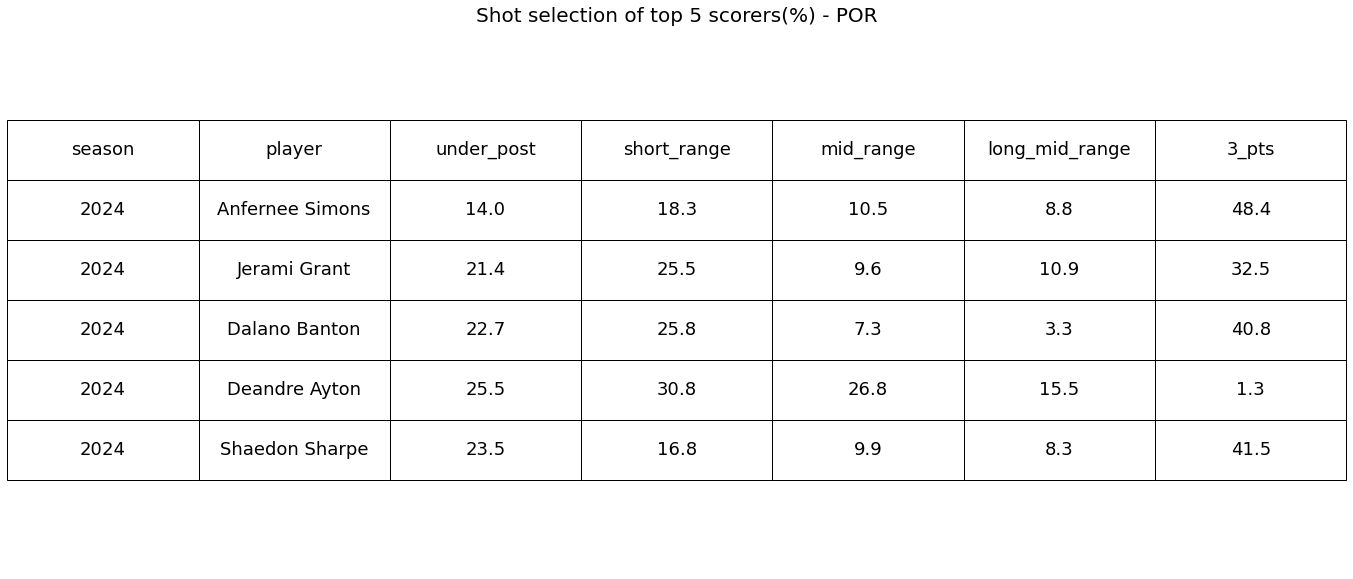

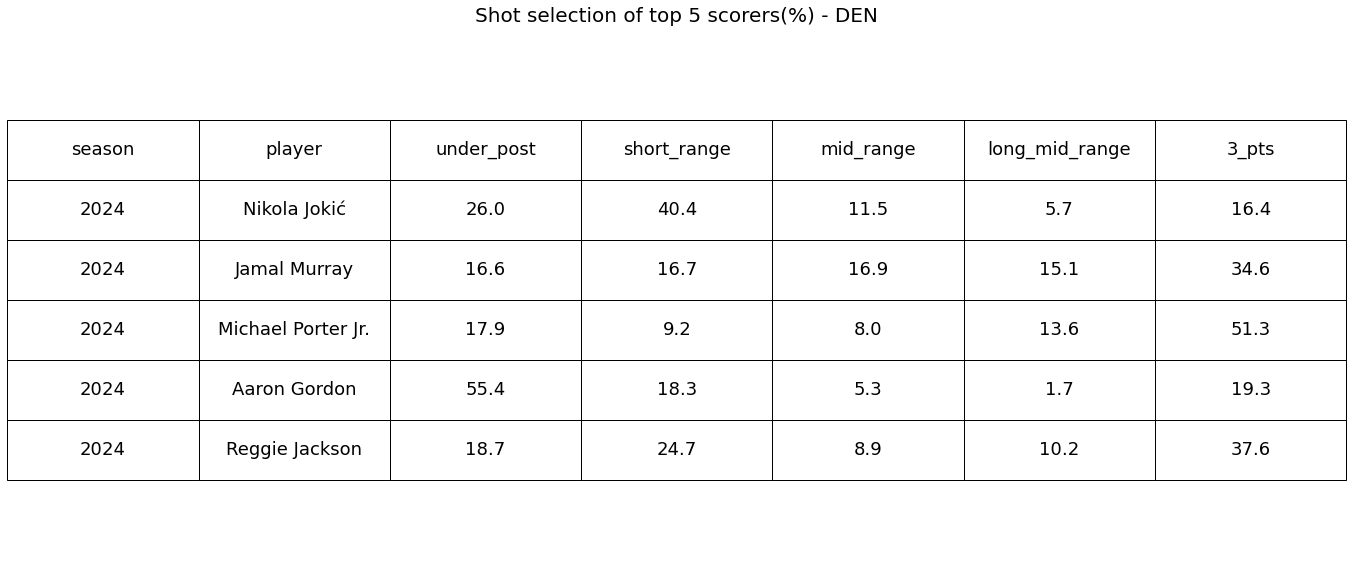

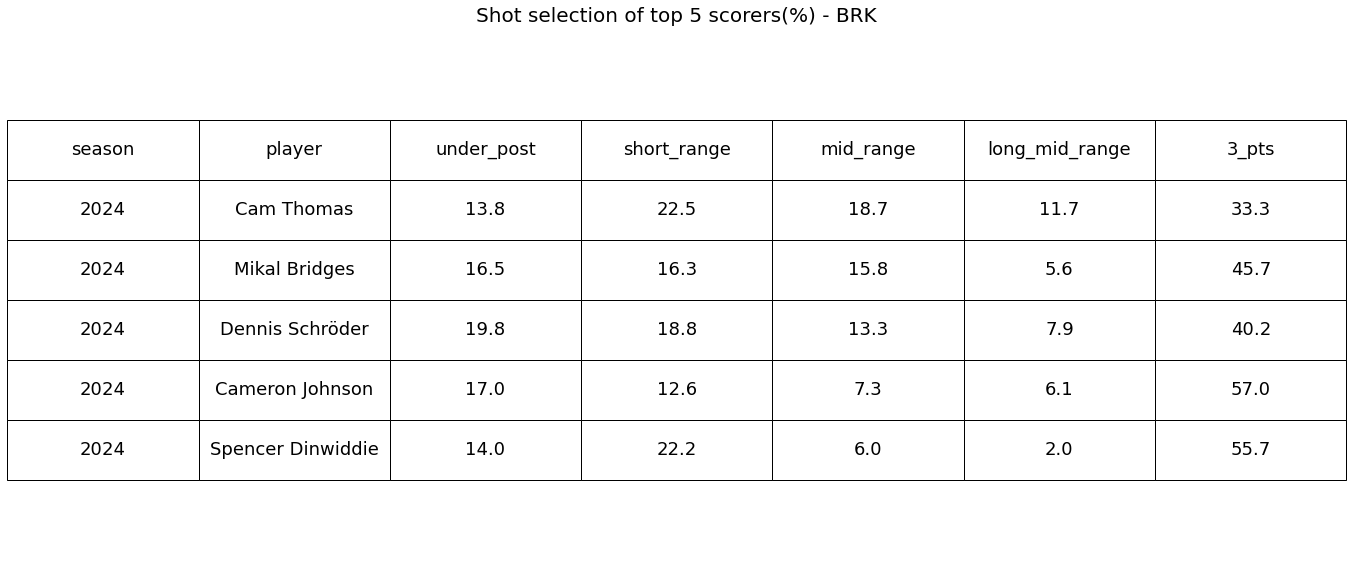

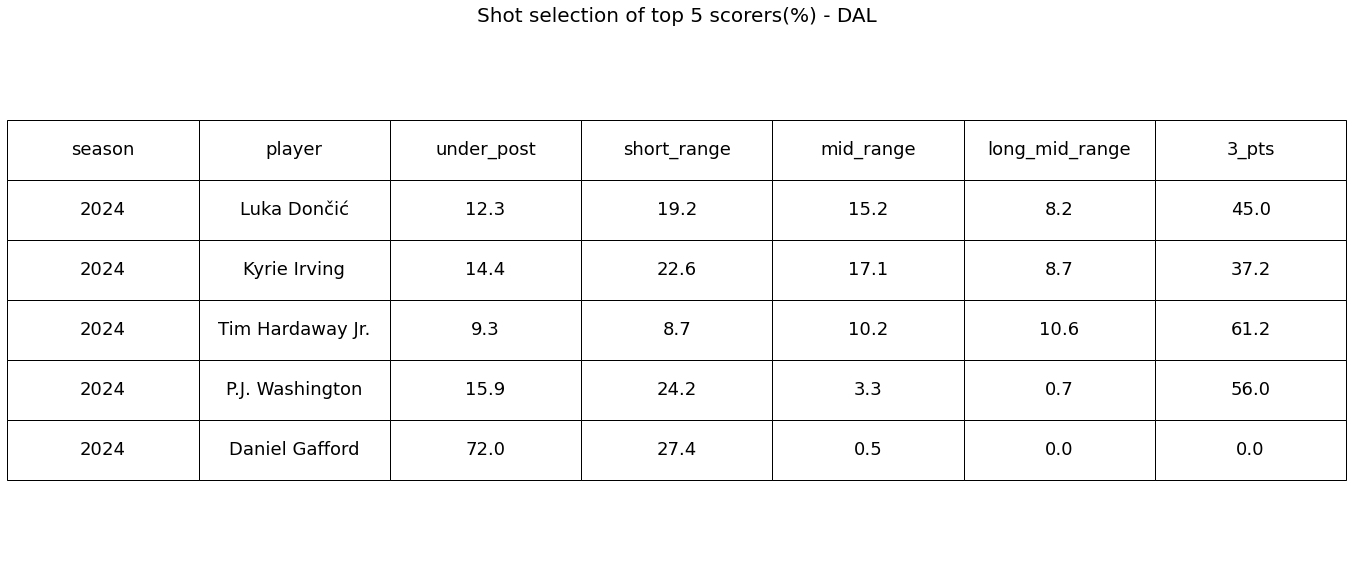

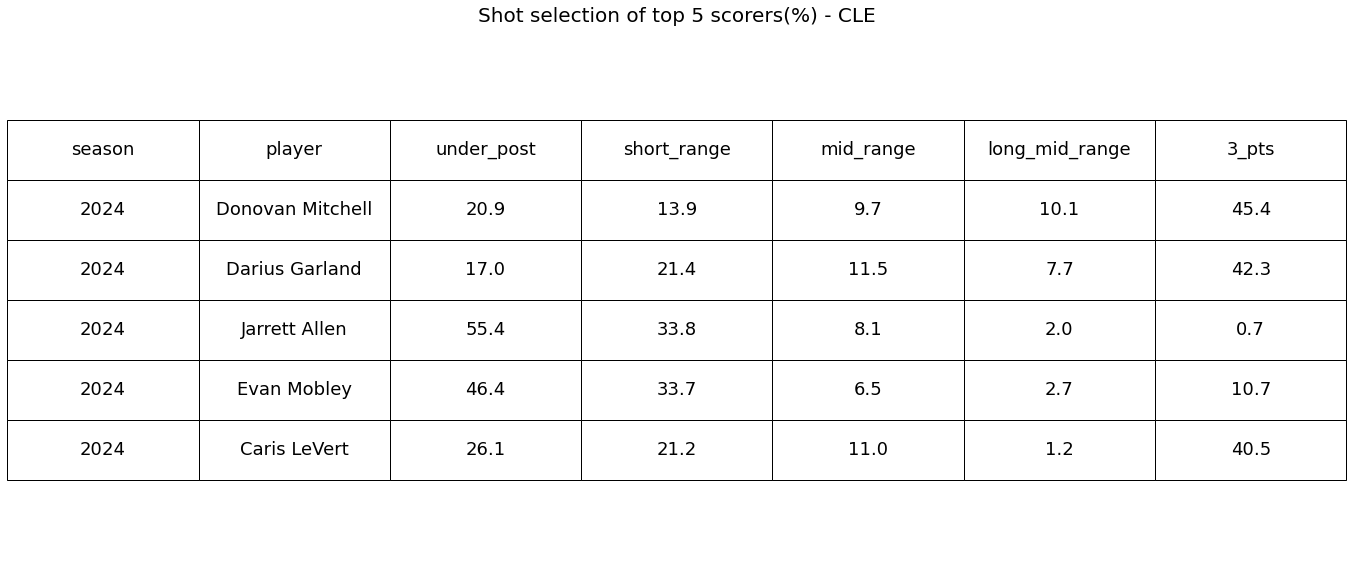

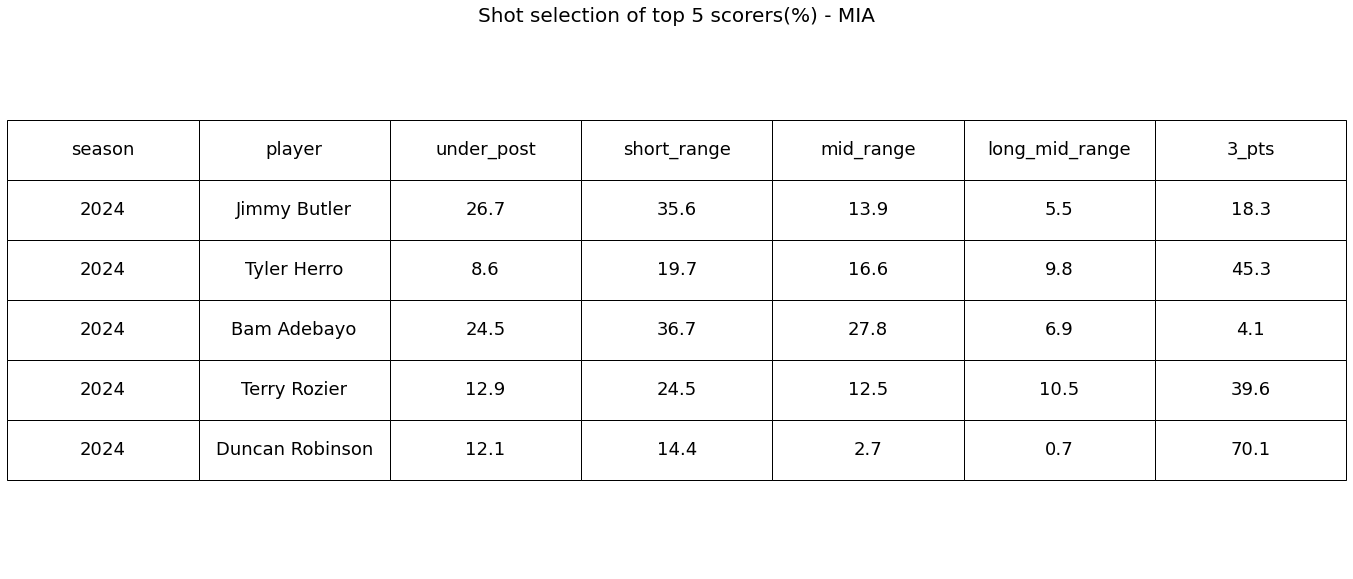

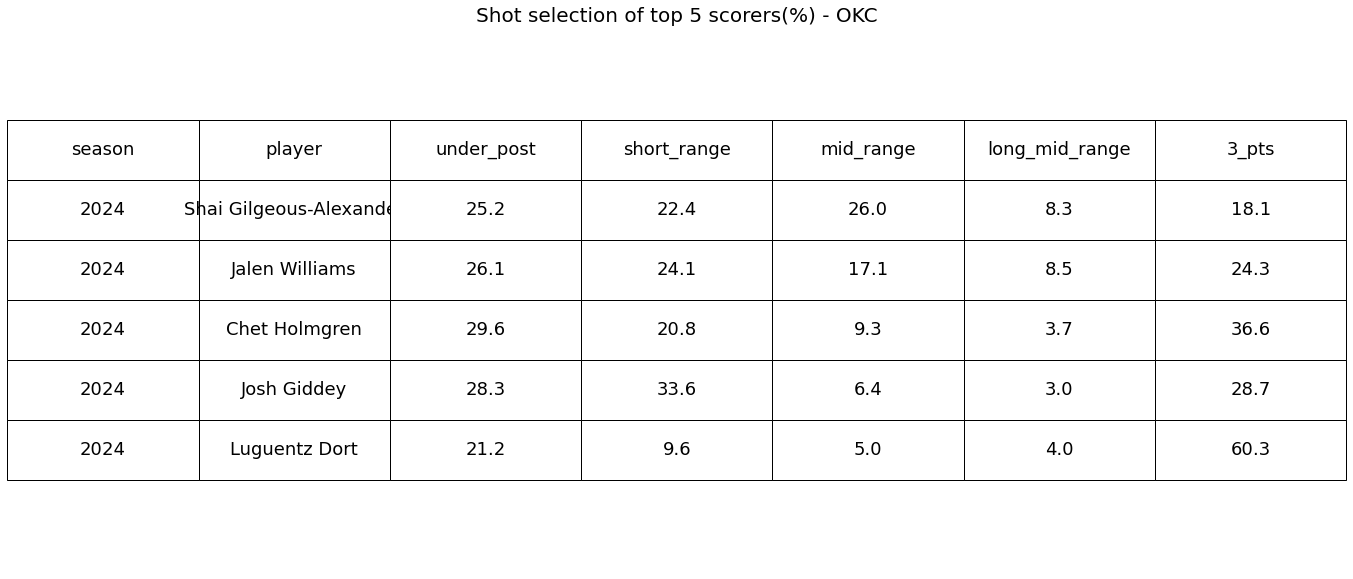

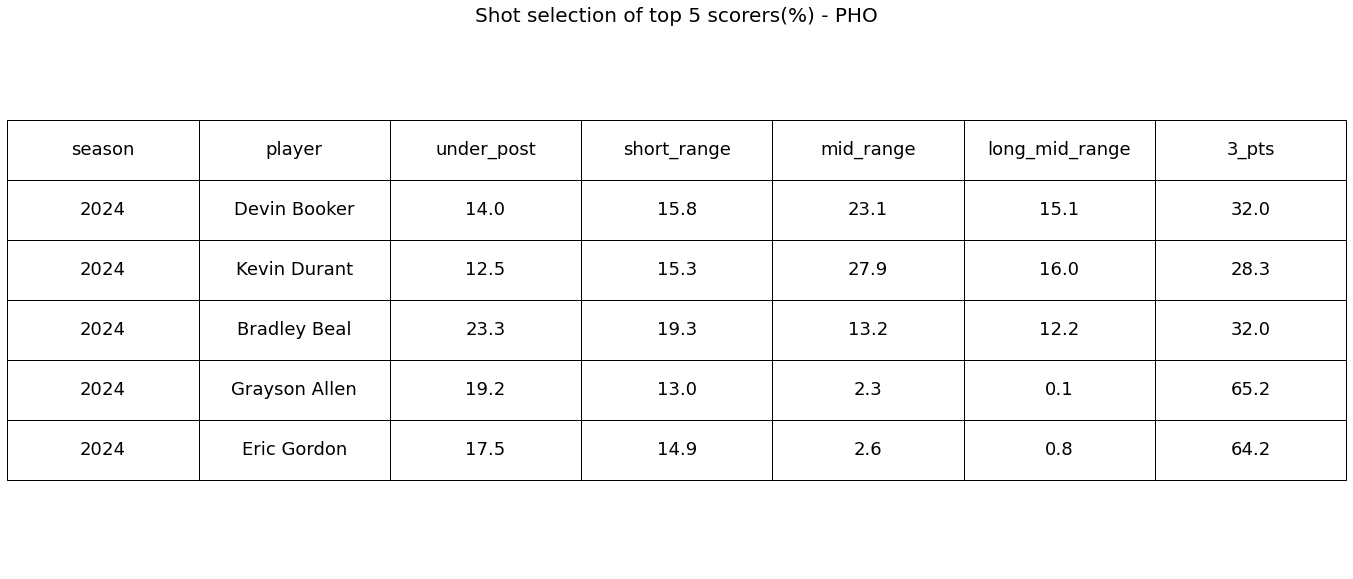

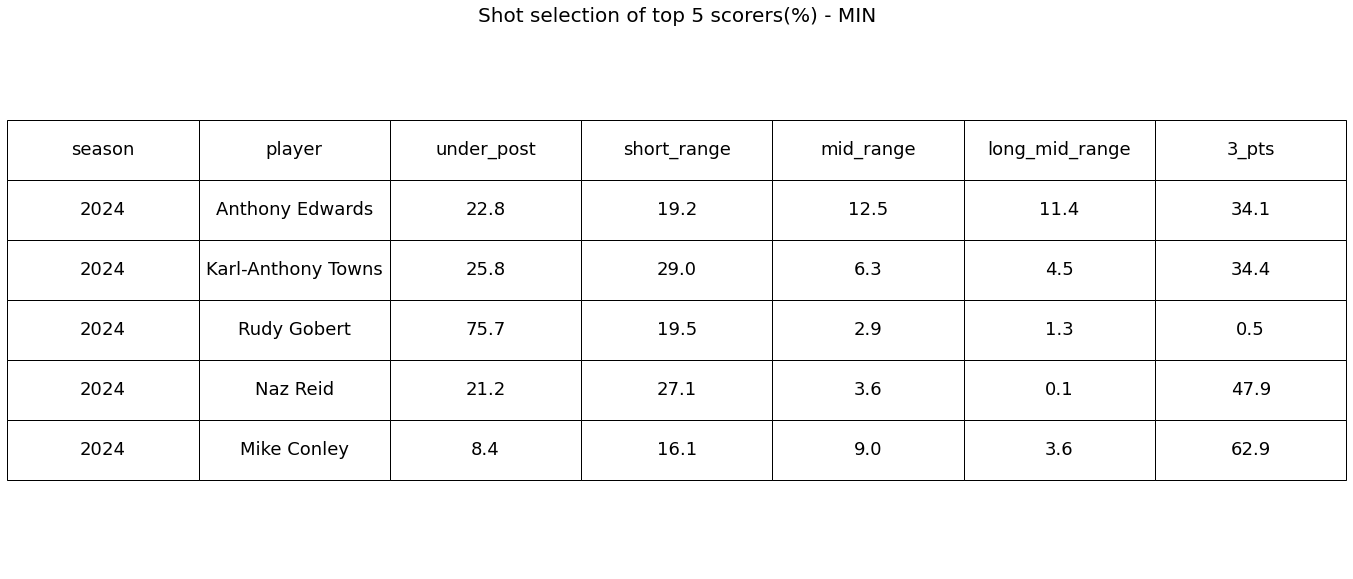

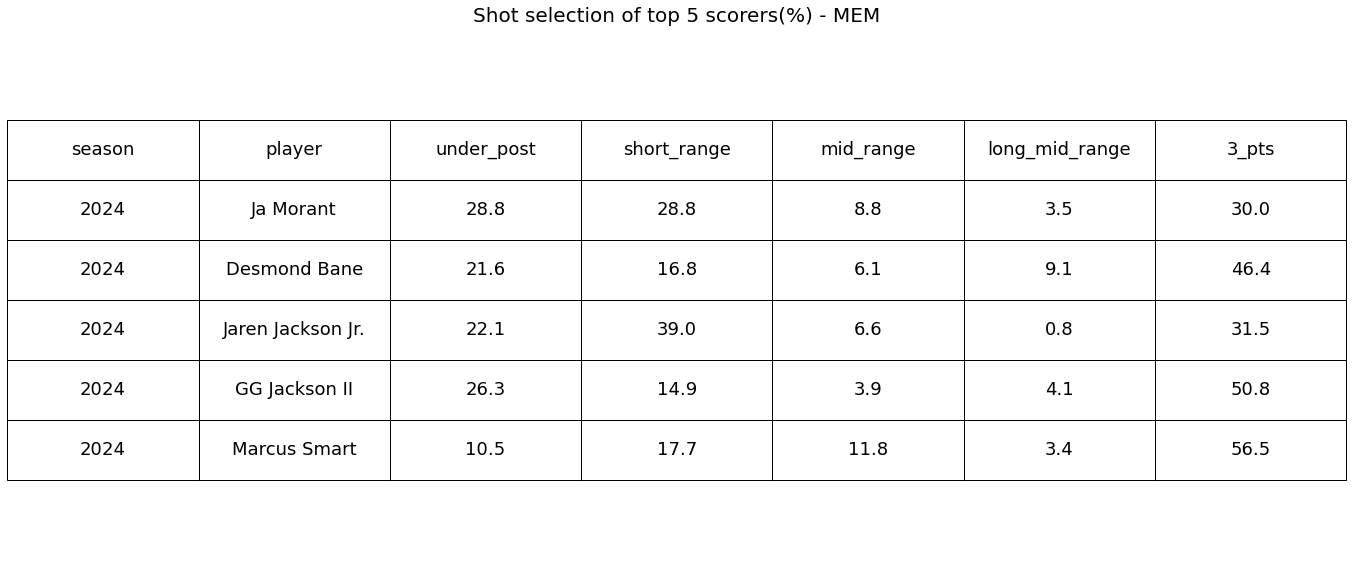

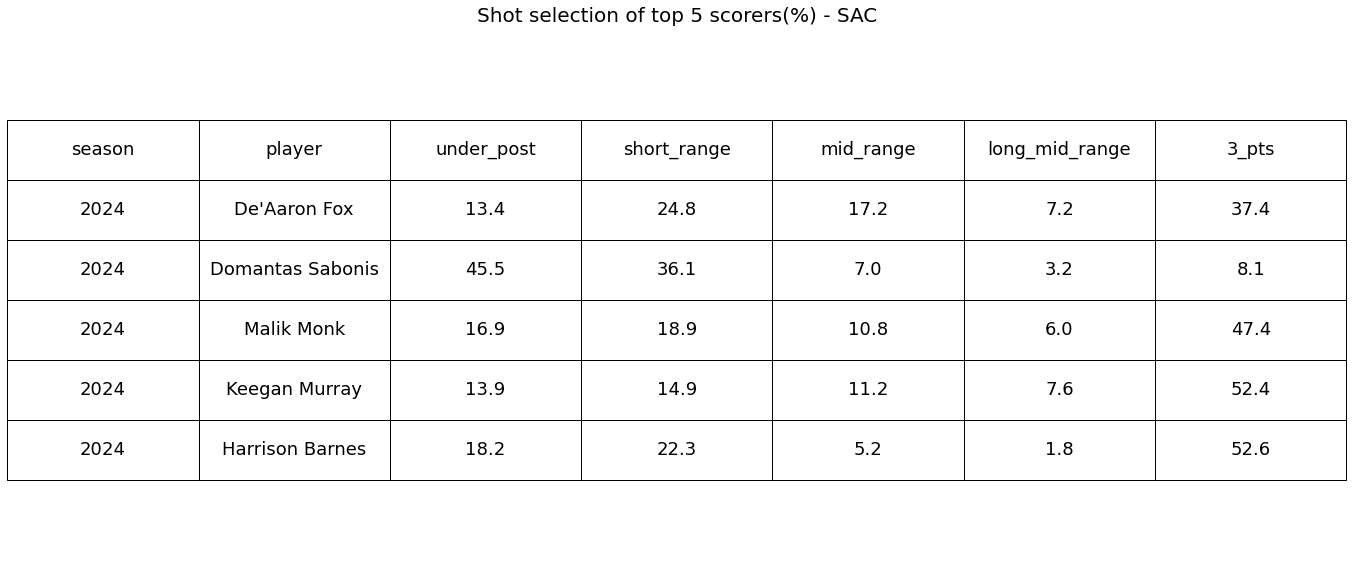

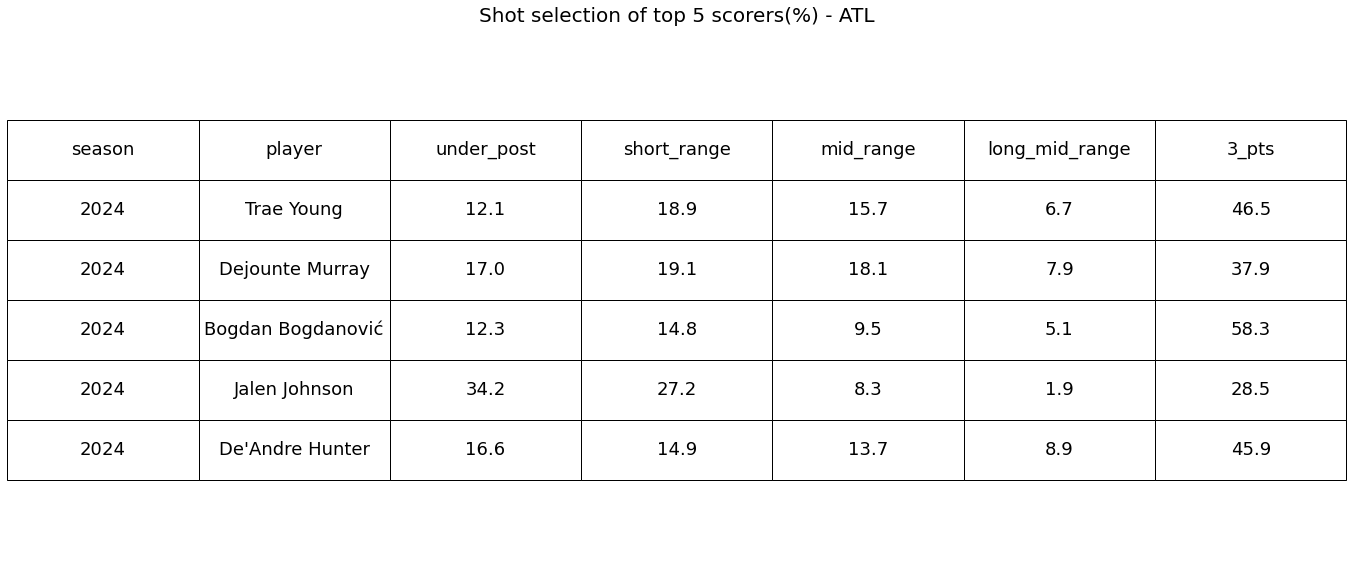

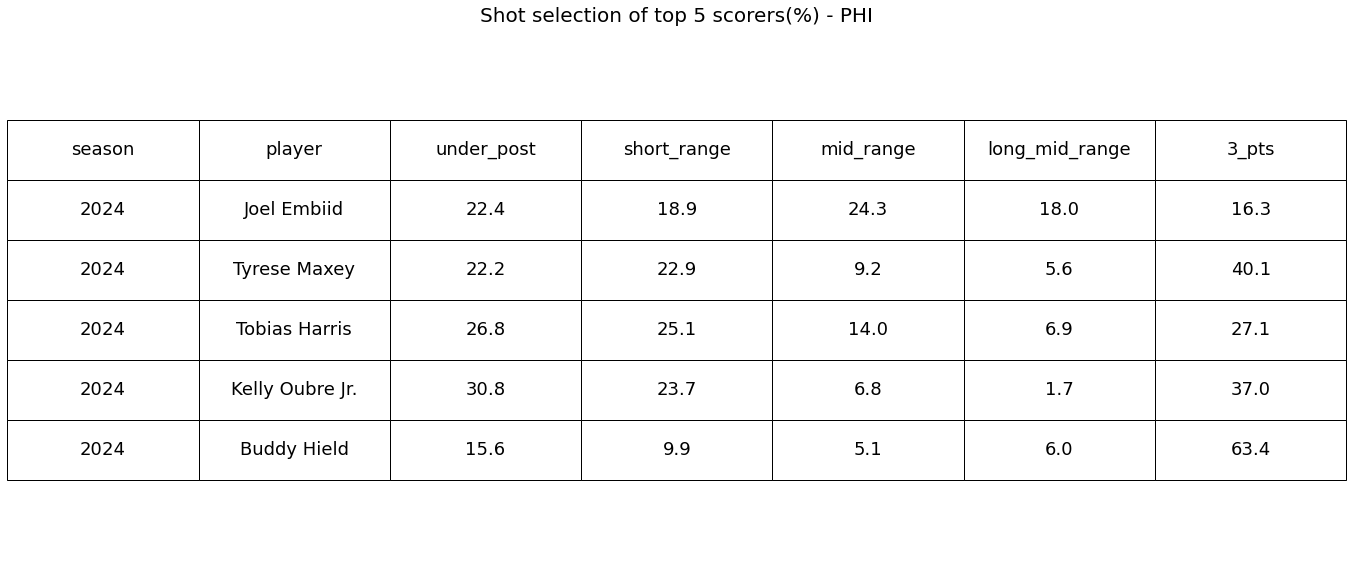

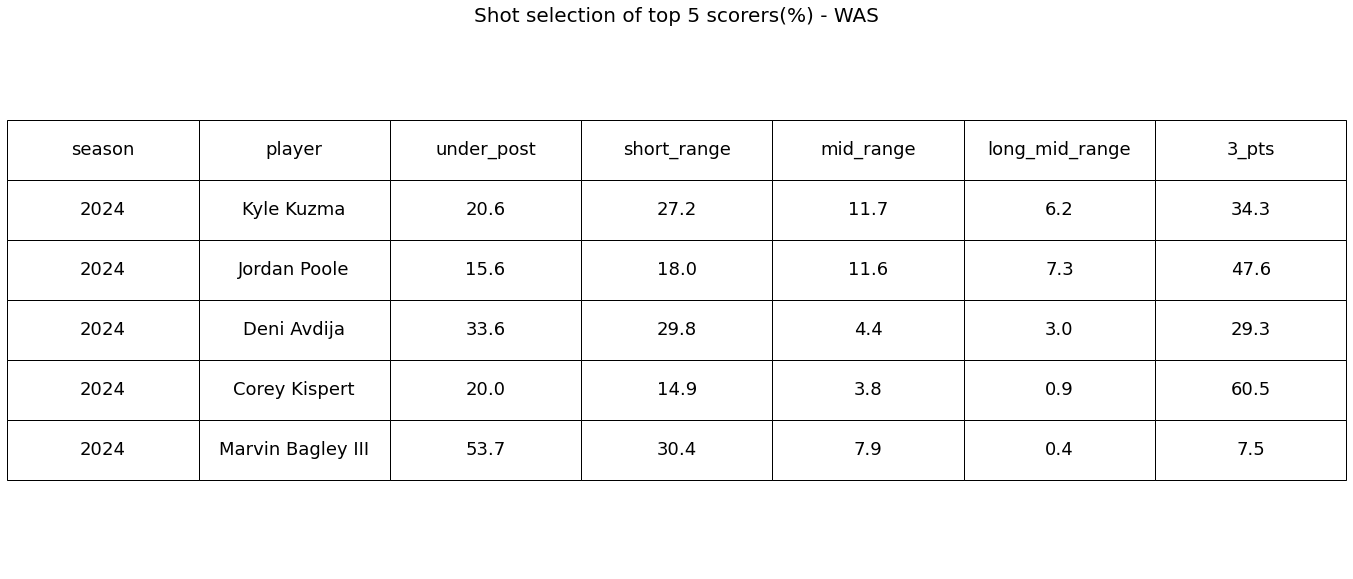

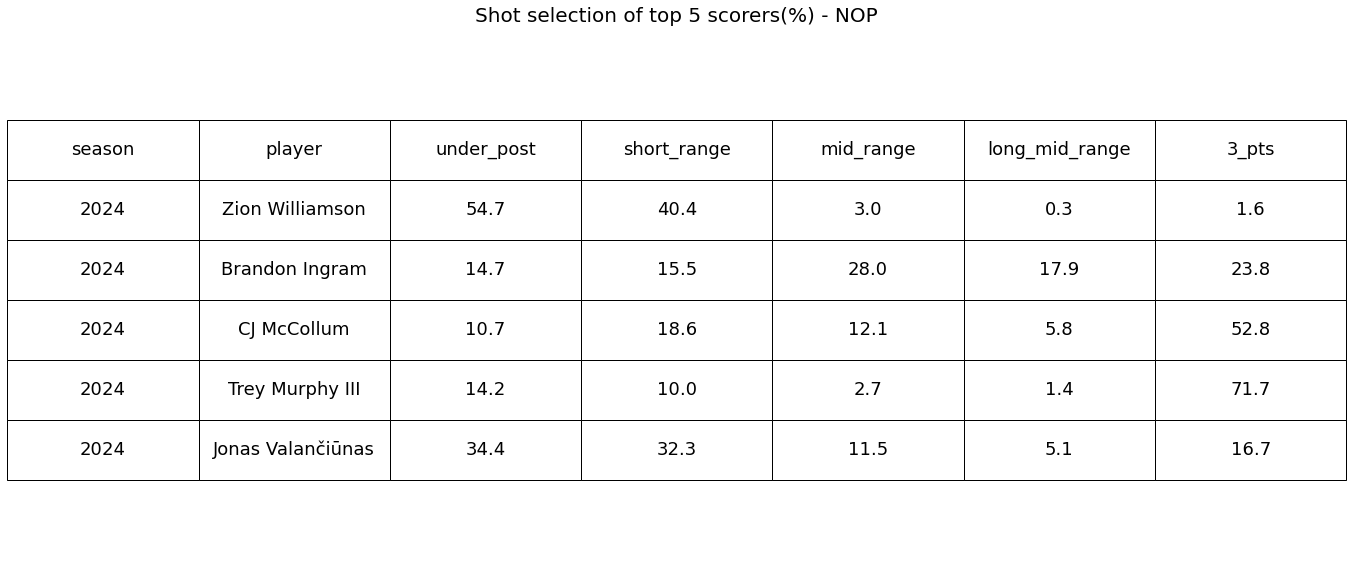

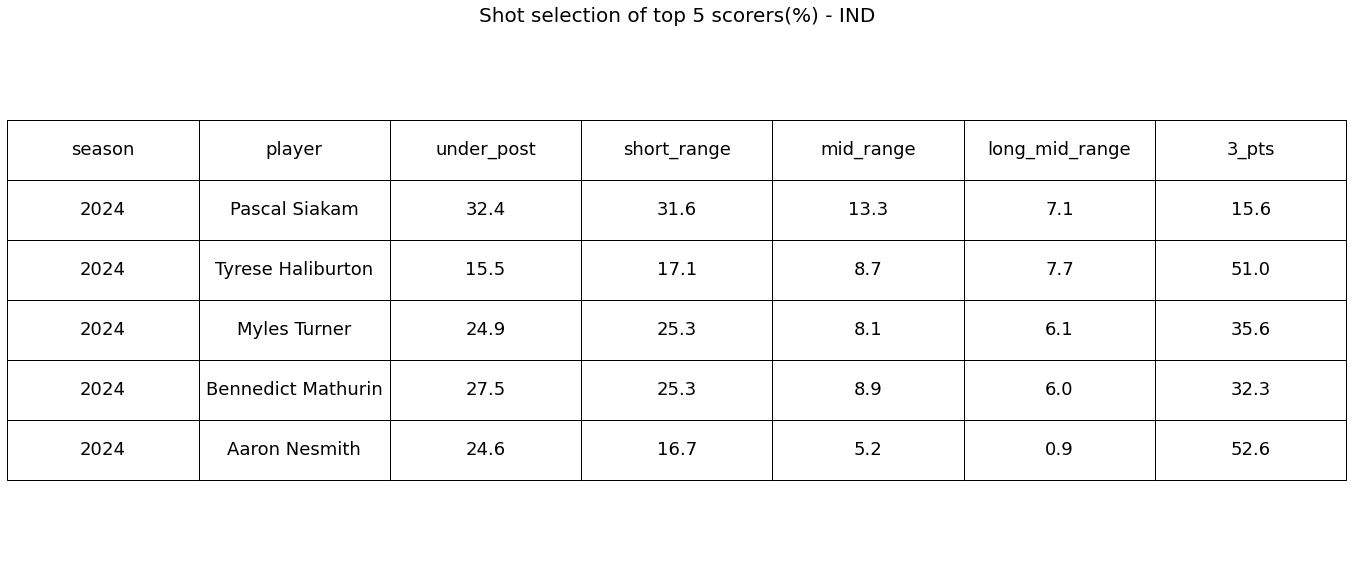

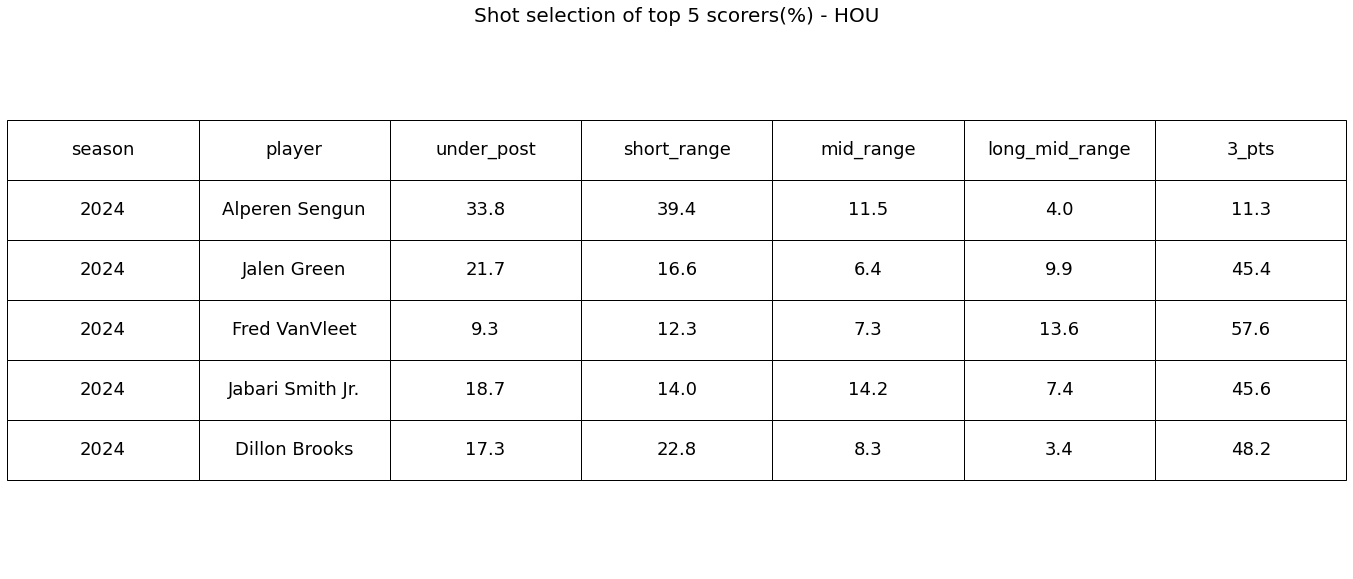

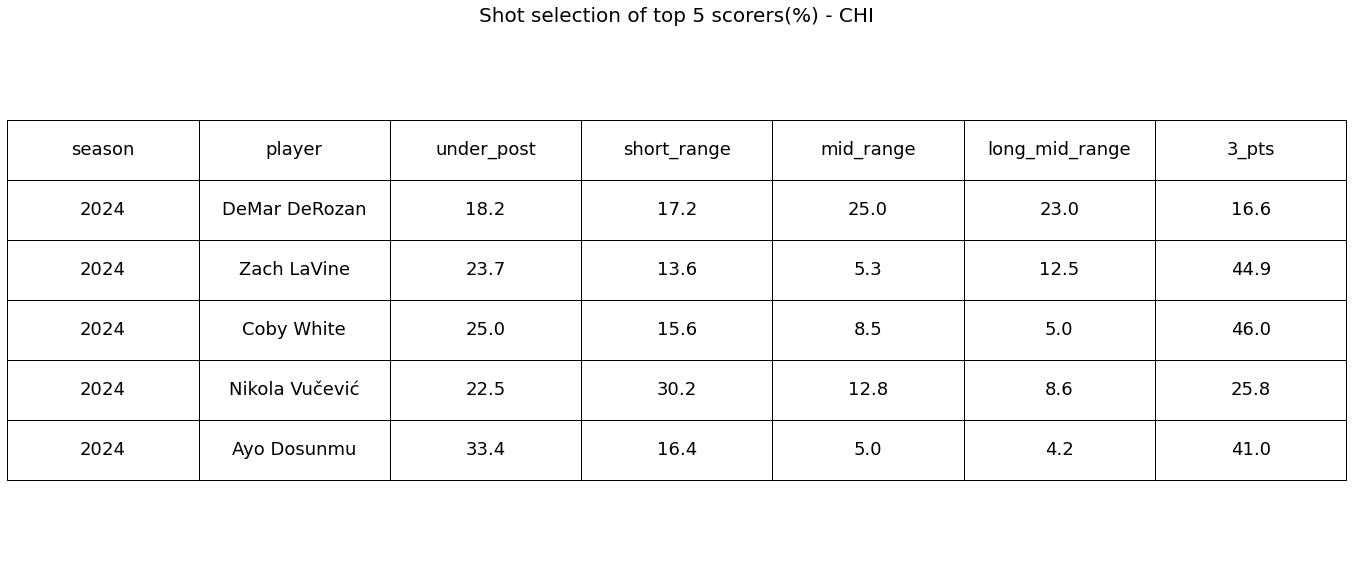

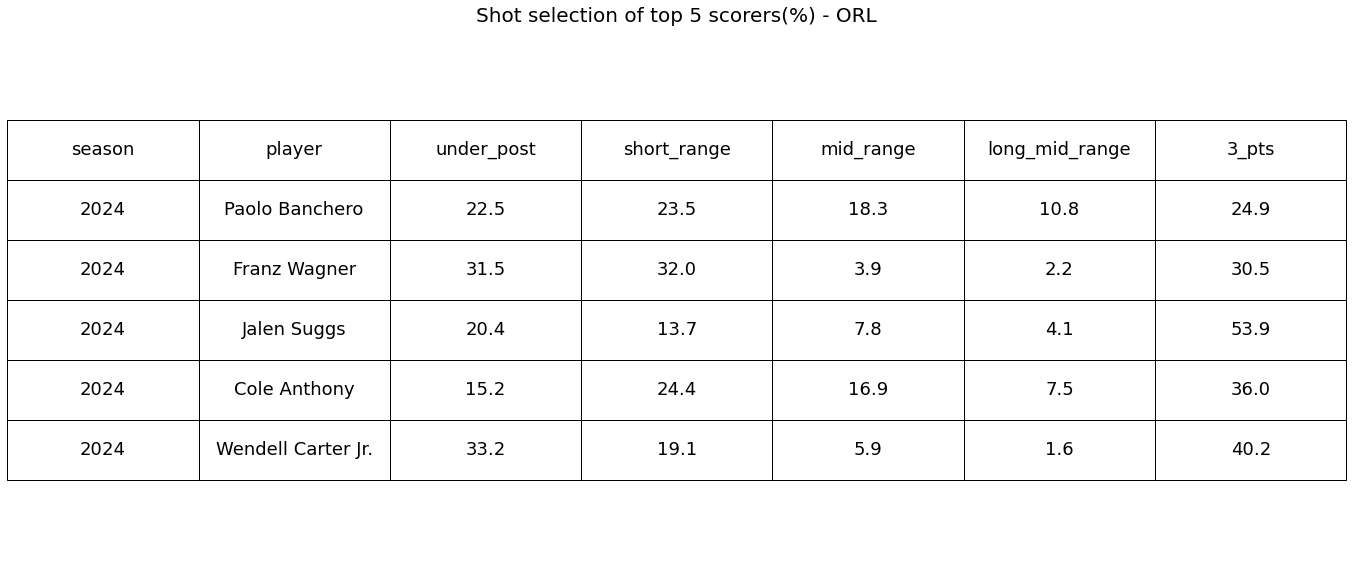

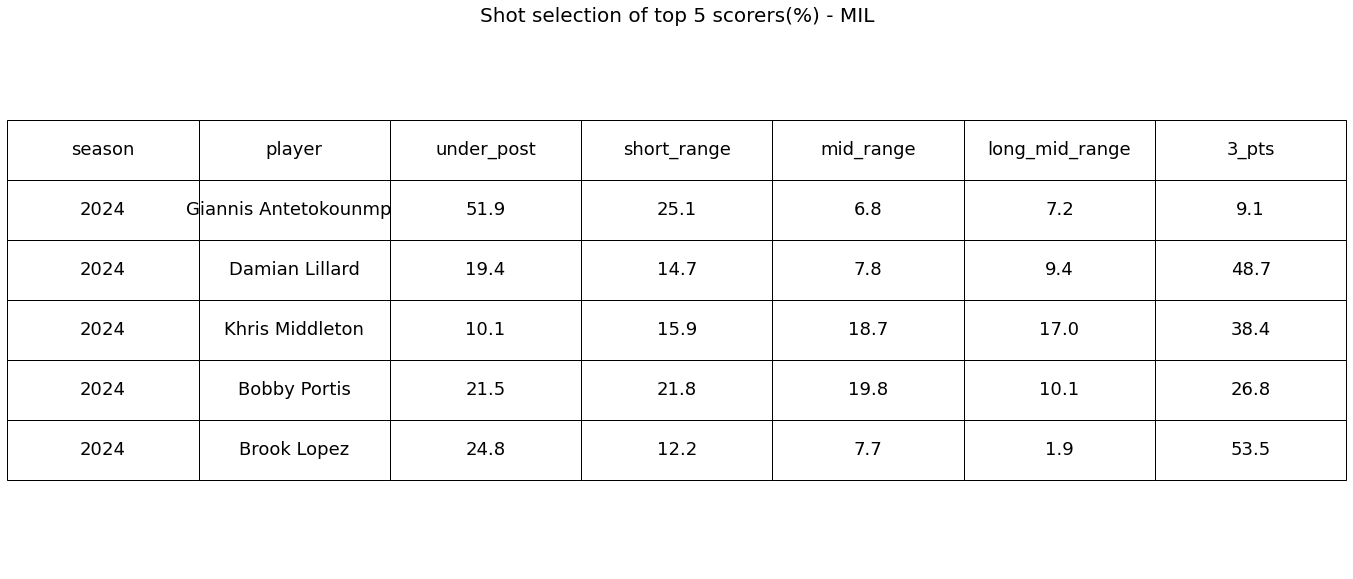

In [7]:
top_scorers_shot_selection = spark.sql("""
SELECT 
s.season,
s.player,
s.tm AS team,
ROUND(percent_fga_from_x0_3_range * 100, 1) AS under_post,
ROUND(percent_fga_from_x3_10_range * 100, 1) AS short_range,
ROUND(percent_fga_from_x10_16_range * 100, 1) AS mid_range,
ROUND(percent_fga_from_x16_3p_range * 100, 1) AS long_mid_range,
ROUND(percent_fga_from_x3p_range * 100, 1) AS 3_pts,
ROW_NUMBER() OVER (PARTITION BY s.tm ORDER BY a.pts_per_game DESC) AS rank
FROM player_shooting s
JOIN player_averages a ON a.player = s.player 
AND a.season = s.season 
AND a.tm = s.tm
WHERE s.season = 2024 

""")

# include only the top 5 scores 
top_scorers_shot_selection = top_scorers_shot_selection.filter("rank <= 5").toPandas()

for team in top_scorers_shot_selection['team'].unique():
    team_data = top_scorers_shot_selection[top_scorers_shot_selection['team'] == team]
    team_data = team_data.drop(columns=['rank', 'team'])
    
    # Set up the figure
    plt.figure(figsize=(20, 10))
    
    # Create table
    table = plt.table(cellText=team_data.values, colLabels=team_data.columns, cellLoc='center', loc='center')
    plt.axis('off')

    plt.title(f"Shot selection of top 5 scorers(%) - {team}", fontsize=20,loc='center')  

    table.auto_set_font_size(False) 
    table.set_fontsize(18)  
    table.scale(1.2, 5)  
    
    plt.show()

# Find the 36 minute averages of players on the team at each position (Example: team LAC)

The 36 minute averages allow coaches to identify highly efficient players that may currently be under utilised with little actual playing time. For instance, on team LAC, Moussa Diabate is a center who is only averaging 5.8 minute per game, however, when looking at his statistics per 36 minutes, he is actually highly efficient among centers on the team. He has the highest average score and number of steals, high number of assists and low number of turn overs. Increasing his playing time might be beneficial to team performance.

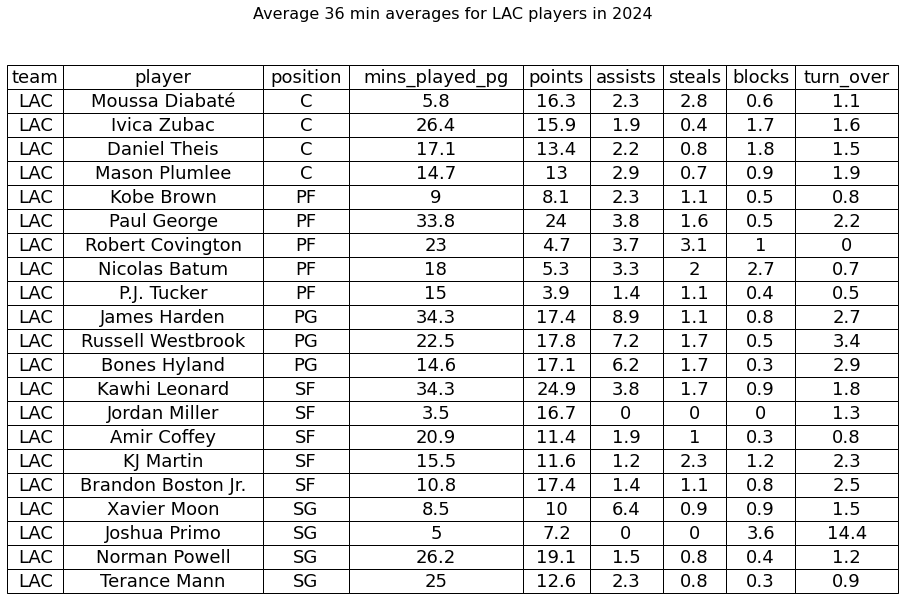

In [8]:
performance_at_position = spark.sql("""
SELECT 
per.tm AS team,
per.player,
per.pos as position,
a.mp_per_game AS mins_played_pg,
per.pts_per_36_min AS points,
per.ast_per_36_min AS assists,
per.stl_per_36_min AS steals,
per.blk_per_36_min AS blocks,
per.tov_per_36_min AS turn_over   
FROM player_averages a
JOIN per_36_min per ON a.player = per.player AND a.season = per.season AND a.tm = per.tm
WHERE per.tm = 'LAC' AND per.season = 2024
ORDER BY per.pos, mins_played_pg DESC
""")

performance_at_position_pd = performance_at_position.toPandas()

# Display more than 20 items by setting a larger figure size
plt.figure(figsize=(12, 8))  # Adjust size as needed

# Create a table
table = plt.table(cellText=performance_at_position_pd.values,colLabels=performance_at_position_pd.columns, 
                  cellLoc='center',loc='center')

table.auto_set_font_size(False) 
table.set_fontsize(18)  
table.scale(1.5, 2)  
table.auto_set_column_width(col=[0, 1, 2, 3, 4, 5, 6, 7, 8]) 

plt.axis('off')
plt.title('Average 36 min averages for LAC players in 2024', fontsize=16, y=1.2)

plt.show()




